In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, clear_output

In [2]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
import time
from ipywidgets import interact, interactive, fixed, interact_manual
import particles  # core module
from particles import distributions as dists  # where probability distributions are defined
from particles import state_space_models as ssm 
from particles import resampling as rs
from particles.core import FeynmanKac
from particles.core import SMC

import ipywidgets
from joblib import Parallel, delayed
import multiprocessing

C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\particles-0.1-py3.7-win-amd64.egg\particles\qmc.py:30: UserWarning: 
Module lowdiscrepancy does not seem to be installed (see INSTALL
notes). You will not be able to run SQMC (quasi-Monte Carlo version
of SMC).

  warnings.warn(qmc_warning)


# Partie gaussienne

In [3]:
sigma= 3
Y= np.random.normal(0,sigma, 25)
Y= np.sort(Y)
np.std(Y)

2.7573864373650703

In [4]:
def r(y):
    m = y % 2
    return m if m < 1 else 2 - m

r= np.vectorize(r)

In [5]:
from scipy.stats import norm

theta=3 #=sigma

def f_x2y(x, theta= theta):
    return norm.ppf(x, scale= theta)

def phi(x, y, theta=theta, G= f_x2y): #y est supposé être déjà trié!!!!!
    y_test= G(x, theta)
    return np.sqrt(np.sum((y-np.sort(y_test))**2))

In [6]:
class FeynmanKacSampling(FeynmanKac):
    def Slice_Sampling(self, x, phi, eps, w):
        """
        x of dimention p
        phi : map     (we must have phi(x) <= e)
        e : treshold
        w : initial search width
        """
        p = x.shape[0]
        #print('---------')
        #print(phi(x))
        #print(x)
        if phi(x) > eps :
            raise Exception('phi(x) must be <= e')
        v = np.random.multivariate_normal(np.zeros(p), np.diag(np.ones(p)))
        u = np.random.uniform(0, w)
        a = - u 
        b = w - u
        #while True :
        for c in range(100):
            z = np.random.uniform(a, b)
            x_prime = r(x + z*v)
            #print(x_prime)
            #print(phi(x_prime))
            if phi(x_prime) <= eps:
                self.z_iter_list.append(z) #stockage des z courants
                self.nb_samp_calls.append(c+1)
                return x_prime
            if z < 0:
                a = z
            else :
                b = z
        self.nb_samp_calls.append(c+1)
        return x*np.nan
        print('Slice Sampling did not terminate')
    
    def random_walk(self, x, phi, eps, w):
        p= x.shape[0]
        if phi(x) > eps :
            raise Exception('phi(x) must be <= e')
        
        for c in range(100):
            x_prime= x+ np.random.normal(loc=0, scale= w)
            if phi(x_prime) <= eps:
                self.nb_samp_calls.append(c+1)
                return x_prime
            
        self.nb_samp_calls.append(c+1)
        return x*np.nan
        print('Random walk did not terminate')
    


In [7]:
class fixed_RE_FK(FeynmanKacSampling):
    
    def __init__(self, eps_list, data, theta=3, G= f_x2y, MK_name= 'Slice_Sampling', phi= phi, shape= None, w=1):
        
        self.eps_list= np.array(eps_list)
        #assert T==self.eps_list.shape[0]
        self.T= len(self.eps_list)
        self.theta= theta
        self.data= np.sort(data)
        
        if shape is None:
            self.shape= data.shape[0]
        else: self.shape=shape
            
        self.G= G
        self.MK_name= MK_name
        self.w= w
        self.z_iter_list= [] #sert à updater le w courant, voir p 14
        self._phi= phi #uniquement dans le but de stocker la fonction complète
        self.phi= lambda x: phi(x, self.data, self.theta, self.G) #phi total
        self.nb_samp_calls= [0]
        
        #if MK_name=='Slice_Sampling':
            #self.MK= self.Slice_Sampling
        #elif MK_name=='random_walk':
            #self.MK= self.random_walk
    
            
    def M0(self, N):
        return np.random.uniform(0,1, size=(N, self.shape))
    
    def M(self, t, xp):
        
        if self.MK_name=='Slice_Sampling':
            self.z_iter_list=[]
            self.nb_samp_calls= []
            xt= np.apply_along_axis(self.Slice_Sampling, 1, xp, phi=self.phi, eps= self.eps_list[t-1], w=self.w)
            self.w= min(1, 2*np.max(np.abs(self.z_iter_list)))
            
        elif self.MK_name=='random_walk':
            xt= np.apply_along_axis(self.random_walk, 1, xp, phi=self.phi, eps= self.eps_list[t-1], w=self.w)

        return xt
    
    
    def logG(self, t, xp, x):
        return np.array(np.log((np.apply_along_axis(self.phi, 1, x)<=self.eps_list[t])*1.))
    
    

In [8]:
class adapt_RE_FK(FeynmanKacSampling):
    
    def __init__(self, T_max, accept_rate, eps_target, data, theta= 3, G= f_x2y, MK_name= 'Slice_Sampling', phi= phi, w=1):
        
        self.eps_list= []
        #assert T==self.eps_list.shape[0]
        #self.T= T
        self.T_max= T_max
        self.accept_rate= accept_rate
        self.eps_target= eps_target
        self.eps= 100000
        self.theta= theta
        self.data= np.sort(data)
        self.shape= data.shape[0]
        self.G= G
        self.MK_name= MK_name
        self.w= w
        self.z_iter_list= [] #sert à updater le w courant, voir p 14
        self._phi= phi #uniquement dans le but de stocker la fonction complète
        self.phi= lambda x: phi(x, self.data, self.theta, self.G) #phi total
        self.nb_samp_calls= [0]
                
        if MK_name=='Slice_Sampling':
            #self.MK= np.vectorize(self.Slice_Sampling, excluded=['phi', 'eps', 'w'])
            self.MK= self.Slice_Sampling
        elif MK_name=='random_walk':
            self.MK= self.random_walk
            
            
    def M0(self, N):
        return np.random.uniform(0,1, size=(N, self.shape))
    
    def M(self, t, xp):
        
        if self.MK_name=='Slice_Sampling':
            self.z_iter_list=[]
            self.nb_samp_calls= []
            xt= np.apply_along_axis(self.Slice_Sampling, 1, xp, phi=self.phi, eps= self.eps_list[t-1], w=self.w)
            self.w= min(1, 2*np.max(np.abs(self.z_iter_list)))
            
        elif self.MK_name=='random_walk':
            xt= np.apply_along_axis(self.random_walk, 1, xp, phi=self.phi, eps= self.eps_list[t-1], w=self.w)
            
        return xt
    
    def logG(self, t, xp, x):
        phi_x_list= np.apply_along_axis(self.phi, 1, x)
        self.eps= np.quantile(phi_x_list, self.accept_rate)
        if self.eps<= self.eps_target:
            self.eps= self.eps_target
        self.eps_list.append(self.eps)
        return np.array(np.log((phi_x_list<=self.eps)*1.))
    
    def done(self, smc):
        #on remplace la condition d'arrêt par une vérification de la valeur de eps
        if smc.t>=self.T_max:
            print('T max reached!!')
            return True
        elif self.eps<= self.eps_target:
            return True
        return False
    
    

In [9]:
class RE_SMC(SMC):

    def __init__(self,
             fk=None,
             N=100,
             qmc=False,
             resampling="systematic",
             ESSrmin=np.inf,
             store_history=False,
             verbose=False,
             summaries=True,
             print_step= True,
             **sum_options):
        
        SMC.__init__(self,
             fk,
             N,
             qmc,
             resampling,
             ESSrmin,
             store_history,
             verbose,
             summaries,
             **sum_options)
        
        self.P=1
        self.P_list= [] #[1]+[np.nan]*(self.fk.T-1)
        self.ESSrmin = np.inf #on resample toujours
        self.computation_time=0
        self.print_step= print_step
        self.aborted= False
        #self.out=  ipywidgets.Output(layout={'border': '1px solid black'})
        
    def update_P(self):
        self.P= self.P* np.mean(self.wgts.W != 0)
        #self.P_list[self.t-1]= self.P
        self.P_list.append(self.P)

    def __next__(self):
        """One step of a particle filter.
        """
        t0= time.time()
        if self.fk.done(self) | self.aborted:
            raise StopIteration
        if self.t == 0:
            self.generate_particles()
        else:
            self.setup_auxiliary_weights()  # APF
            if self.qmc:
                self.resample_move_qmc()
            else:
                self.resample_move()
        self.reweight_particles()
        self.compute_summaries()
        self.t += 1 
        
        self.update_P() #on calcule le p courant
        t1= time.time()-t0
        self.computation_time+= t1
        
        if np.isnan(self.wgts.ESS): 
            print('>> ESS null: SMC aborted')
            self.aborted= True
            return

        if self.print_step:
            print('step: '+str(self.t-1)+',  eps: '+str(round(self.fk.eps_list[self.t-1],2))+
                ',  P: '+ '{:0.2e}'.format(self.P)+ ',  time: '+str(round(t1,2))+',  ESS: '+str(round(self.wgts.ESS))+
                 ',  mean samp calls: '+str(round(np.mean(self.fk.nb_samp_calls),1)))
        #display(self.out)
        #self.out.clear_output()
        #self.out.append_stdout('step: '+str(self.t-1)+', eps: '+str(self.fk.eps_list[self.t-1])+
        #        ' , P: '+ '{:0.2e}'.format(self.P)+ ', time: '+str(round(t1,2)))



Implémentation de PMMH

In [10]:
class RE_ABC(object):
    
    def __init__(self, theta0, prior, q, q_ker, refk, N=500, print_step=False):
        #on donne un modèle de FeynmanKac à l'init pour récupérer ses paramètres
        
        #etat du PMMH
        self.theta= theta0
        self.L_tp=None
        self.theta_list= []
        self.L_list= []
        self.t=0
        self.nb_accepted=0
        self.re_smc= None #last run smc object
        self.nb_abort= 0
        
        #paramètres PMMH
        self.q= q
        self.q_ker= q_ker
        self.prior= prior
        self.N= N
        self.print_step= print_step
        
        #paramètres FK
        self.refk_type= type(refk).__name__
        self.refk= refk 
        
    def compute_L0(self):
        refk= self.refk
        if self.refk_type== 'fixed_RE_FK':
            fk= fixed_RE_FK(refk.eps_list, refk.data, self.theta, refk.G, refk.MK_name, refk._phi)
            
        elif self.refk_type== 'adapt_RE_FK':
            fk= adapt_RE_FK(refk.T_max, refk.accept_rate, refk.eps_target, refk.data, self.theta, refk.G, refk.MK_name,
                            refk._phi)
        #init smc
        re_smc= RE_SMC(fk, N=self.N, print_step= False)
        re_smc.run()
        
        if re_smc.aborted:
            print('>> Iteration failed')
            self.nb_abort+=1
            if self.nb_abort>=10:
                print('ABC error')
                return
            self.compute_L0()
            return
            
        self.L_tp= re_smc.P
        self.re_smc= re_smc
        self.theta_list.append(self.theta)
        self.L_list.append(self.L_tp)
        self.t+=1
        self.nb_accepted+=1
        
    def compute_post(self):
        #new theta
        theta_prime= self.q_ker(self.theta)
        
        #init new feynmankac
        refk= self.refk
        
        if self.refk_type== 'fixed_RE_FK':
            fk= fixed_RE_FK( refk.eps_list, refk.data, theta_prime, refk.G, refk.MK_name, refk._phi)
            
        elif self.refk_type== 'adapt_RE_FK':
            fk= adapt_RE_FK(refk.T_max, refk.accept_rate, theta_prime, refk.data, refk.theta, refk.G, refk.MK_name,
                            refk._phi)
        #init smc
        re_smc= RE_SMC(fk, N=self.N, print_step= False)
        
        #draw u
        u= np.random.uniform(0,1)
        
        #np.float64 permet d'obtenir inf si division par 0 ( si le prior de theta prime est nul)
        stop_test_value= np.float64(u * self.prior(self.theta) * self.L_tp * self.q(theta_prime, self.theta)) \
                            /( self.prior(theta_prime) * self.q(self.theta, theta_prime))
        
        if self.print_step:
            print('proposal: '+str(theta_prime))
            print('previous: '+str(self.theta))
            
        while not re_smc.fk.done(re_smc):
            next(re_smc)
            
            if re_smc.aborted:
                
                if self.print_step:
                    print('>> Iteration failed')
                    
                self.nb_abort+=1
                if self.nb_abort>=10:
                    print('PMMH error')
                    return
                self.compute_post()
                return
        
            if re_smc.P< stop_test_value:
                
                if self.print_step:
                    print('-------')
                    print('L_prime:    '+str(re_smc.P))
                    print('L_tp:       '+str(self.L_tp))
                    print('prob ratio: '+str(( self.prior(theta_prime) * self.q(self.theta, theta_prime) * re_smc.P)/
                          (self.prior(self.theta) * self.L_tp * self.q(theta_prime, self.theta))))
                    print('u:          '+str(u))
                    print('>> Rejected\n')

                self.t+=1
                self.theta_list.append(self.theta)
                self.L_list.append(self.L_tp)
                return
        
        if re_smc.aborted:
            print('>> Iteration failed')
            self.compute_post()
            return
        
        if self.print_step:
            print('-------')
            print('L_prime:    '+str(re_smc.P))
            print('L_tp:       '+str(self.L_tp))
            print('prob ratio: '+str(( self.prior(theta_prime) * self.q(self.theta, theta_prime) * re_smc.P)/
                  (self.prior(self.theta) * self.L_tp * self.q(theta_prime, self.theta))))
            print('u:          '+str(u))
            print('>> Accepted\n')
            
        self.theta= theta_prime
        self.L_tp= re_smc.P
        self.re_smc= re_smc
        self.theta_list.append(self.theta)
        self.L_list.append(self.L_tp)
        self.t+=1
        self.nb_accepted+=1
    
    def __next__(self):
        self.nb_abort=0
        if self.print_step: 
            print('--------------------------')
            print('step: ' +str(self.t)+', theta: '+str(self.theta)+', nb accepted: '+str(self.nb_accepted))
        else:
            if self.t%50==0: print(self.t)
                
        if self.t==0:
            self.compute_L0()
        else:
            self.compute_post()
    
    def run(self, n):
        while self.t<n:
            self.__next__()

## Tests

### tests re ABC

#### Définition des distributions

In [364]:
scale= 1
#scale= 2.25

def unif10(x):
    if 0<x and x<10:
        return 1/10
    else: return 0

def norm_pdf(theta_prime, theta):
    return norm.pdf(theta_prime, loc= theta, scale=scale)

def norm_kernel(theta):
    return norm.rvs(loc= theta, scale= scale)

#### Adapt pour les la liste des epsilon

In [266]:
fk1= adapt_RE_FK(200, 0.5, eps_target=5, theta= 8, data=Y)
re_smc1= RE_SMC(fk=fk1, N=50)

In [13]:
next(re_smc1)

step: 0,  eps: 26.43,  P: 5.00e-01,  time: 0.02,  ESS: 25,  mean samp calls: 0.0


C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log


In [267]:
re_smc1.run()

C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log


step: 0,  eps: 26.42,  P: 5.00e-01,  time: 0.02,  ESS: 25,  mean samp calls: 0.0
step: 1,  eps: 22.34,  P: 2.50e-01,  time: 0.07,  ESS: 25,  mean samp calls: 1.9
step: 2,  eps: 19.47,  P: 1.25e-01,  time: 0.07,  ESS: 25,  mean samp calls: 2.5
step: 3,  eps: 17.63,  P: 6.25e-02,  time: 0.07,  ESS: 25,  mean samp calls: 3.3
step: 4,  eps: 15.77,  P: 3.12e-02,  time: 0.07,  ESS: 25,  mean samp calls: 3.6
step: 5,  eps: 14.75,  P: 1.56e-02,  time: 0.09,  ESS: 25,  mean samp calls: 3.2
step: 6,  eps: 13.73,  P: 7.81e-03,  time: 0.08,  ESS: 25,  mean samp calls: 4.4
step: 7,  eps: 12.67,  P: 3.91e-03,  time: 0.06,  ESS: 25,  mean samp calls: 2.4
step: 8,  eps: 12.2,  P: 1.95e-03,  time: 0.06,  ESS: 25,  mean samp calls: 2.9
step: 9,  eps: 11.23,  P: 9.77e-04,  time: 0.06,  ESS: 25,  mean samp calls: 2.5
step: 10,  eps: 10.49,  P: 4.88e-04,  time: 0.08,  ESS: 25,  mean samp calls: 2.7
step: 11,  eps: 9.83,  P: 2.44e-04,  time: 0.06,  ESS: 25,  mean samp calls: 2.4
step: 12,  eps: 8.97,  P: 1.

In [268]:
eps_list1= re_smc1.fk.eps_list

In [269]:
fk1= fixed_RE_FK( eps_list1, Y, 3)
re_smc1= RE_SMC(fk=fk1, N=100)

In [270]:
re_smc1.run()

step: 0,  eps: 26.42,  P: 1.00e+00,  time: 0.13,  ESS: 100,  mean samp calls: 0.0
step: 1,  eps: 22.34,  P: 1.00e+00,  time: 0.12,  ESS: 100,  mean samp calls: 1.0
step: 2,  eps: 19.47,  P: 1.00e+00,  time: 0.08,  ESS: 100,  mean samp calls: 1.0
step: 3,  eps: 17.63,  P: 1.00e+00,  time: 0.1,  ESS: 100,  mean samp calls: 1.0
step: 4,  eps: 15.77,  P: 1.00e+00,  time: 0.09,  ESS: 100,  mean samp calls: 1.0
step: 5,  eps: 14.75,  P: 1.00e+00,  time: 0.12,  ESS: 100,  mean samp calls: 1.0
step: 6,  eps: 13.73,  P: 1.00e+00,  time: 0.09,  ESS: 100,  mean samp calls: 1.0
step: 7,  eps: 12.67,  P: 1.00e+00,  time: 0.08,  ESS: 100,  mean samp calls: 1.0
step: 8,  eps: 12.2,  P: 1.00e+00,  time: 0.08,  ESS: 100,  mean samp calls: 1.0


C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


step: 9,  eps: 11.23,  P: 9.90e-01,  time: 0.11,  ESS: 99,  mean samp calls: 1.0
step: 10,  eps: 10.49,  P: 9.90e-01,  time: 0.1,  ESS: 100,  mean samp calls: 1.0
step: 11,  eps: 9.83,  P: 9.90e-01,  time: 0.09,  ESS: 100,  mean samp calls: 1.0
step: 12,  eps: 8.97,  P: 9.70e-01,  time: 0.09,  ESS: 98,  mean samp calls: 1.0
step: 13,  eps: 8.22,  P: 9.70e-01,  time: 0.1,  ESS: 100,  mean samp calls: 1.0
step: 14,  eps: 7.35,  P: 9.12e-01,  time: 0.09,  ESS: 94,  mean samp calls: 1.0
step: 15,  eps: 6.65,  P: 8.48e-01,  time: 0.11,  ESS: 93,  mean samp calls: 1.0
step: 16,  eps: 6.07,  P: 8.14e-01,  time: 0.09,  ESS: 96,  mean samp calls: 1.1
step: 17,  eps: 5.47,  P: 7.57e-01,  time: 0.12,  ESS: 93,  mean samp calls: 1.2
step: 18,  eps: 5.08,  P: 6.89e-01,  time: 0.1,  ESS: 91,  mean samp calls: 1.3
step: 19,  eps: 5.0,  P: 6.68e-01,  time: 0.09,  ESS: 97,  mean samp calls: 1.4


#### ABC

In [287]:
#scale= 1
fk1= fixed_RE_FK( eps_list1, Y)
re_abc1= RE_ABC(theta0= 3, prior= unif10, q= norm_pdf, q_ker= norm_kernel, refk= fk1, N=50, print_step=True)

In [272]:
next(re_abc1)
re_abc1.__dict__

--------------------------
step: 0, theta: 3, nb accepted: 0


C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


{'theta': 3,
 'L_tp': 0.5773593201868799,
 'theta_list': [3],
 'L_list': [0.5773593201868799],
 't': 1,
 'nb_accepted': 1,
 're_smc': <__main__.RE_SMC at 0x185311cbef0>,
 'nb_abort': 0,
 'q': <function __main__.norm_pdf(theta_prime, theta)>,
 'q_ker': <function __main__.norm_kernel(theta)>,
 'prior': <function __main__.unif10(x)>,
 'N': 50,
 'print_step': True,
 'refk_type': 'fixed_RE_FK',
 'refk': <__main__.fixed_RE_FK at 0x1855d5ea7b8>}

In [293]:
%%time
re_abc1.run(1000)
#6 min 50 pour 500

--------------------------
step: 500, theta: 2.238488059873173, nb accepted: 279
proposal: 1.000320577215644
previous: 2.238488059873173


C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


-------
L_prime:    0.324
L_tp:       0.64182730752
prob ratio: 0.5048086863924902
u:          0.7317168436960602
>> Rejected

--------------------------
step: 501, theta: 2.238488059873173, nb accepted: 279
proposal: 2.714853981553655
previous: 2.238488059873173
-------
L_prime:    0.7013597183999999
L_tp:       0.64182730752
prob ratio: 1.0927545621423171
u:          0.07879670345685497
>> Accepted

--------------------------
step: 502, theta: 2.714853981553655, nb accepted: 280
proposal: 4.54761167474863
previous: 2.714853981553655
-------
L_prime:    0.4459111858962432
L_tp:       0.7013597183999999
prob ratio: 0.6357810039525692
u:          0.6586365227926069
>> Rejected

--------------------------
step: 503, theta: 2.714853981553655, nb accepted: 280
proposal: 3.273440135330919
previous: 2.714853981553655
-------
L_prime:    0.48404832679526394
L_tp:       0.7013597183999999
prob ratio: 0.6901570108695653
u:          0.40990592983606877
>> Accepted

--------------------------
ste

-------
L_prime:    0.23590923417599996
L_tp:       0.7647304089599999
prob ratio: 0.3084867966697261
u:          0.013194061834254756
>> Accepted

--------------------------
step: 531, theta: 1.927724189765791, nb accepted: 296
proposal: 0.7015492908067869
previous: 1.927724189765791
-------
L_prime:    0.0014212799999999998
L_tp:       0.23590923417599996
prob ratio: 0.006024689982841683
u:          0.13365971897089568
>> Rejected

--------------------------
step: 532, theta: 1.927724189765791, nb accepted: 296
proposal: 1.7762810193364145
previous: 1.927724189765791
-------
L_prime:    0.15956717027328002
L_tp:       0.23590923417599996
prob ratio: 0.6763922185183943
u:          0.7469670504230762
>> Rejected

--------------------------
step: 533, theta: 1.927724189765791, nb accepted: 296
proposal: 2.529999275725859
previous: 1.927724189765791
-------
L_prime:    0.7623655199999999
L_tp:       0.23590923417599996
prob ratio: 3.231605251328303
u:          0.8421261900388631
>> Accep

-------
L_prime:    0.3385627477585918
L_tp:       0.008066613141665206
prob ratio: 41.97086705569987
u:          0.6174738706821842
>> Accepted

--------------------------
step: 560, theta: 3.4172016378632986, nb accepted: 307
proposal: 2.637674861784924
previous: 3.4172016378632986
-------
L_prime:    0.7166066687999999
L_tp:       0.3385627477585918
prob ratio: 2.1166140502586184
u:          0.1921268834034745
>> Accepted

--------------------------
step: 561, theta: 2.637674861784924, nb accepted: 308
proposal: 3.15985452400372
previous: 2.637674861784924
-------
L_prime:    0.515676484512
L_tp:       0.7166066687999999
prob ratio: 0.7196088272183269
u:          0.8283862901579669
>> Rejected

--------------------------
step: 562, theta: 2.637674861784924, nb accepted: 308
proposal: 4.223788443478637
previous: 2.637674861784924
-------
L_prime:    0.31499072961458996
L_tp:       0.7166066687999999
prob ratio: 0.4395587472581863
u:          0.46801136391145803
>> Rejected

---------

-------
L_prime:    0.6270308351999998
L_tp:       0.42535703347200005
prob ratio: 1.4741282871987007
u:          0.7142328316785153
>> Accepted

--------------------------
step: 590, theta: 2.344649383266595, nb accepted: 326
proposal: 2.5306114660977324
previous: 2.344649383266595
-------
L_prime:    0.76167168
L_tp:       0.6270308351999998
prob ratio: 1.2147276293949
u:          0.1022716410179163
>> Accepted

--------------------------
step: 591, theta: 2.5306114660977324, nb accepted: 327
proposal: 2.4762687601260063
previous: 2.5306114660977324
-------
L_prime:    0.6829363199999999
L_tp:       0.76167168
prob ratio: 0.8966282165039927
u:          0.9091736251971149
>> Rejected

--------------------------
step: 592, theta: 2.5306114660977324, nb accepted: 327
proposal: 2.352913444392468
previous: 2.5306114660977324
-------
L_prime:    0.6428487340799999
L_tp:       0.76167168
prob ratio: 0.8439971590909089
u:          0.32218623876052144
>> Accepted

--------------------------
s

C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\particles-0.1-py3.7-win-amd64.egg\particles\resampling.py:158: RuntimeWarning: invalid value encountered in subtract
  w = np.exp(lw - lw.max())
C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\particles-0.1-py3.7-win-amd64.egg\particles\resampling.py:299: RuntimeWarning: invalid value encountered in subtract
  V = np.exp(v - m)


-------
L_prime:    0.6723905126399999
L_tp:       0.7312048127999999
prob ratio: 0.9195652173913044
u:          0.9407783455261879
>> Rejected

--------------------------
step: 614, theta: 2.6669764103143008, nb accepted: 338
proposal: 2.891394713731382
previous: 2.6669764103143008
-------
L_prime:    0.627008126976
L_tp:       0.7312048127999999
prob ratio: 0.8574999999999999
u:          0.21980986729893526
>> Accepted

--------------------------
step: 615, theta: 2.891394713731382, nb accepted: 339
proposal: 2.9801592305339253
previous: 2.891394713731382
-------
L_prime:    0.5566201804800001
L_tp:       0.627008126976
prob ratio: 0.8877399774138905
u:          0.8271672309996022
>> Accepted

--------------------------
step: 616, theta: 2.9801592305339253, nb accepted: 340
proposal: 2.831949492604683
previous: 2.9801592305339253
-------
L_prime:    0.7980103434239999
L_tp:       0.5566201804800001
prob ratio: 1.4336712383224008
u:          0.7393566346223874
>> Accepted

-----------

-------
L_prime:    0.7318407810559999
L_tp:       0.6211098879999999
prob ratio: 1.178279069767442
u:          0.45133482754989684
>> Accepted

--------------------------
step: 644, theta: 2.8539372723126357, nb accepted: 357
proposal: 4.302107110118451
previous: 2.8539372723126357
-------
L_prime:    0.19420958541068892
L_tp:       0.7318407810559999
prob ratio: 0.26537136278529977
u:          0.27148499618178157
>> Rejected

--------------------------
step: 645, theta: 2.8539372723126357, nb accepted: 357
proposal: 2.8799756656229825
previous: 2.8539372723126357
-------
L_prime:    0.715309056
L_tp:       0.7318407810559999
prob ratio: 0.9774107627178883
u:          0.3120272639550752
>> Accepted

--------------------------
step: 646, theta: 2.8799756656229825, nb accepted: 358
proposal: 2.0314175436671427
previous: 2.8799756656229825
-------
L_prime:    0.53744768
L_tp:       0.715309056
prob ratio: 0.7513503086419753
u:          0.7762848765740726
>> Rejected

--------------------

-------
L_prime:    0.32799232
L_tp:       0.7976928735999997
prob ratio: 0.4111761943161982
u:          0.5935908706861083
>> Rejected

--------------------------
step: 674, theta: 2.6147585099621304, nb accepted: 371
proposal: 3.249699180518647
previous: 2.6147585099621304
-------
L_prime:    0.41913664514641913
L_tp:       0.7976928735999997
prob ratio: 0.5254361158510157
u:          0.4687129311934508
>> Accepted

--------------------------
step: 675, theta: 3.249699180518647, nb accepted: 372
proposal: 2.6365331142229187
previous: 3.249699180518647
-------
L_prime:    0.8500544962559998
L_tp:       0.41913664514641913
prob ratio: 2.0281082699391413
u:          0.5804519246236114
>> Accepted

--------------------------
step: 676, theta: 2.6365331142229187, nb accepted: 373
proposal: 2.2204864134537146
previous: 2.6365331142229187
-------
L_prime:    0.5617382399999999
L_tp:       0.8500544962559998
prob ratio: 0.6608261499399547
u:          0.10226983159666192
>> Accepted

--------

-------
L_prime:    0.655892041728
L_tp:       0.6123343951155199
prob ratio: 1.0711337578942672
u:          0.2330269921996212
>> Accepted

--------------------------
step: 704, theta: 2.778666427798078, nb accepted: 388
proposal: 4.50562258859903
previous: 2.778666427798078
-------
L_prime:    0.5430062776319999
L_tp:       0.655892041728
prob ratio: 0.8278897182551668
u:          0.9597173842683165
>> Rejected

--------------------------
step: 705, theta: 2.778666427798078, nb accepted: 388
proposal: 3.016862112058755
previous: 2.778666427798078
-------
L_prime:    0.646119161856
L_tp:       0.655892041728
prob ratio: 0.9850998651451047
u:          0.12848294509217817
>> Accepted

--------------------------
step: 706, theta: 3.016862112058755, nb accepted: 389
proposal: 1.8970391390205068
previous: 3.016862112058755
-------
L_prime:    0.267076656
L_tp:       0.646119161856
prob ratio: 0.41335510810856146
u:          0.4576891497943052
>> Rejected

--------------------------
step: 7

-------
L_prime:    0.51781632
L_tp:       0.7785540223999999
prob ratio: 0.6651000509942262
u:          0.7298302654027675
>> Rejected

--------------------------
step: 734, theta: 2.608106776255207, nb accepted: 402
proposal: 2.556427407194407
previous: 2.608106776255207
-------
L_prime:    0.7328666419200001
L_tp:       0.7785540223999999
prob ratio: 0.9413176489164334
u:          0.20642885592795723
>> Accepted

--------------------------
step: 735, theta: 2.556427407194407, nb accepted: 403
proposal: 2.409768481494122
previous: 2.556427407194407
-------
L_prime:    0.827904
L_tp:       0.7328666419200001
prob ratio: 1.1296789247099805
u:          0.4530178004686215
>> Accepted

--------------------------
step: 736, theta: 2.409768481494122, nb accepted: 404
proposal: 3.9215073008106556
previous: 2.409768481494122
-------
L_prime:    0.43739342438400003
L_tp:       0.827904
prob ratio: 0.5283141818181819
u:          0.6987871381029302
>> Rejected

--------------------------
step: 7

-------
L_prime:    0.22464
L_tp:       0.7807206847999999
prob ratio: 0.2877341466334363
u:          0.4738852534459975
>> Rejected

--------------------------
step: 764, theta: 2.4450937854017223, nb accepted: 418
proposal: 1.2086484847547052
previous: 2.4450937854017223
-------
L_prime:    0.07762896
L_tp:       0.7807206847999999
prob ratio: 0.0994324366080892
u:          0.3156663232732606
>> Rejected

--------------------------
step: 765, theta: 2.4450937854017223, nb accepted: 418
proposal: 0.6690298040636262
previous: 2.4450937854017223
>> ESS null: SMC aborted
>> Iteration failed
proposal: 3.279167111033733
previous: 2.4450937854017223
-------
L_prime:    0.4733528462401535
L_tp:       0.7807206847999999
prob ratio: 0.6063024273033243
u:          0.1350629560378489
>> Accepted

--------------------------
step: 766, theta: 3.279167111033733, nb accepted: 419
proposal: 2.7534636893752156
previous: 3.279167111033733
-------
L_prime:    0.5765748645887999
L_tp:       0.47335284624

-------
L_prime:    0.5903106048
L_tp:       0.7651196927999999
prob ratio: 0.771527135368486
u:          0.9267425021207566
>> Rejected

--------------------------
step: 793, theta: 2.677111609050386, nb accepted: 437
proposal: 3.106683127698717
previous: 2.677111609050386
-------
L_prime:    0.6563070976000001
L_tp:       0.7651196927999999
prob ratio: 0.8577835648148149
u:          0.2934035625109851
>> Accepted

--------------------------
step: 794, theta: 3.106683127698717, nb accepted: 438
proposal: 4.081589685830353
previous: 3.106683127698717
-------
L_prime:    0.38076669886464
L_tp:       0.6563070976000001
prob ratio: 0.5801654442821615
u:          0.6927092631441794
>> Rejected

--------------------------
step: 795, theta: 3.106683127698717, nb accepted: 438
proposal: 2.289371673761872
previous: 3.106683127698717
-------
L_prime:    0.7175985868799999
L_tp:       0.6563070976000001
prob ratio: 1.093388429752066
u:          0.49294400056552157
>> Accepted

------------------

-------
L_prime:    0.6303661056000001
L_tp:       0.566113525189632
prob ratio: 1.113497695340957
u:          0.8310756427945518
>> Accepted

--------------------------
step: 822, theta: 3.121658502526626, nb accepted: 449
proposal: 4.731754417438179
previous: 3.121658502526626
-------
L_prime:    0.5854464
L_tp:       0.6303661056000001
prob ratio: 0.928740290442418
u:          0.9310537904039901
>> Rejected

--------------------------
step: 823, theta: 3.121658502526626, nb accepted: 449
proposal: 2.9619440736431417
previous: 3.121658502526626
-------
L_prime:    0.634345434906624
L_tp:       0.6303661056000001
prob ratio: 1.0063127272727272
u:          0.4927172958807974
>> Accepted

--------------------------
step: 824, theta: 2.9619440736431417, nb accepted: 450
proposal: 0.8847234272766968
previous: 2.9619440736431417
-------
L_prime:    0.11968000000000001
L_tp:       0.634345434906624
prob ratio: 0.18866692091449666
u:          0.8739661785182007
>> Rejected

-----------------

-------
L_prime:    0.45553158295142404
L_tp:       0.589032576
prob ratio: 0.7733555010570825
u:          0.06826431636277175
>> Accepted

--------------------------
step: 852, theta: 3.337965047228643, nb accepted: 468
proposal: 4.512291965745435
previous: 3.337965047228643
-------
L_prime:    0.18231037154406524
L_tp:       0.45553158295142404
prob ratio: 0.40021455891787433
u:          0.5365422541567176
>> Rejected

--------------------------
step: 853, theta: 3.337965047228643, nb accepted: 468
proposal: 3.802661741539754
previous: 3.337965047228643
-------
L_prime:    0.2787711976723968
L_tp:       0.45553158295142404
prob ratio: 0.6119689788932237
u:          0.7442145208038874
>> Rejected

--------------------------
step: 854, theta: 3.337965047228643, nb accepted: 468
proposal: 4.779267524098012
previous: 3.337965047228643
-------
L_prime:    0.052879747304482035
L_tp:       0.45553158295142404
prob ratio: 0.11608360272600661
u:          0.196886748077171
>> Rejected

-------

-------
L_prime:    0.45477810443519995
L_tp:       0.6295190528
prob ratio: 0.72242150958326
u:          0.03454214531147226
>> Accepted

--------------------------
step: 881, theta: 2.175097992483307, nb accepted: 487
proposal: 1.6598515546142578
previous: 2.175097992483307
-------
L_prime:    0.12451864319999999
L_tp:       0.45477810443519995
prob ratio: 0.27380087560425265
u:          0.6384822685230226
>> Rejected

--------------------------
step: 882, theta: 2.175097992483307, nb accepted: 487
proposal: 1.523503396372749
previous: 2.175097992483307
-------
L_prime:    0.37124736
L_tp:       0.45477810443519995
prob ratio: 0.8163263718710934
u:          0.9524249562110397
>> Rejected

--------------------------
step: 883, theta: 2.175097992483307, nb accepted: 487
proposal: 3.4505751720692746
previous: 2.175097992483307
-------
L_prime:    0.35584241172479997
L_tp:       0.45477810443519995
prob ratio: 0.782452823155876
u:          0.9264115290279833
>> Rejected

----------------

-------
L_prime:    0.42534912
L_tp:       0.6406387384319999
prob ratio: 0.6639453634056948
u:          0.13177058561609334
>> Accepted

--------------------------
step: 911, theta: 2.1469322346891655, nb accepted: 504
proposal: -0.011410743008402502
previous: 2.1469322346891655
>> ESS null: SMC aborted
>> Iteration failed
proposal: 3.8647838811185644
previous: 2.1469322346891655
-------
L_prime:    0.29519864300460436
L_tp:       0.42534912
prob ratio: 0.6940149376695649
u:          0.8256719969310512
>> Rejected

--------------------------
step: 912, theta: 2.1469322346891655, nb accepted: 504
proposal: 2.1925280517883023
previous: 2.1469322346891655
-------
L_prime:    0.562193178624
L_tp:       0.42534912
prob ratio: 1.3217217391304348
u:          0.659846542714809
>> Accepted

--------------------------
step: 913, theta: 2.1925280517883023, nb accepted: 505
proposal: 2.0680684938067713
previous: 2.1925280517883023
-------
L_prime:    0.5719988736
L_tp:       0.562193178624
prob r

-------
L_prime:    0.3213616967634125
L_tp:       0.76167168
prob ratio: 0.42191629963636357
u:          0.1020759786287363
>> Accepted

--------------------------
step: 940, theta: 3.4254613358677126, nb accepted: 522
proposal: 2.5665418045168
previous: 3.4254613358677126
-------
L_prime:    0.733545222144
L_tp:       0.3213616967634125
prob ratio: 2.282615599593496
u:          0.06456458393431919
>> Accepted

--------------------------
step: 941, theta: 2.5665418045168, nb accepted: 523
proposal: 2.4665564712446244
previous: 2.5665418045168
-------
L_prime:    0.7169347584
L_tp:       0.733545222144
prob ratio: 0.9773559103889314
u:          0.4817008420116119
>> Accepted

--------------------------
step: 942, theta: 2.4665564712446244, nb accepted: 524
proposal: 1.6080352907581883
previous: 2.4665564712446244
-------
L_prime:    0.15235309440000003
L_tp:       0.7169347584
prob ratio: 0.21250621847378412
u:          0.4070663609978591
>> Rejected

--------------------------
step: 9

-------
L_prime:    0.25039872
L_tp:       0.73286664192
prob ratio: 0.34167023804493696
u:          0.5119253027339413
>> Rejected

--------------------------
step: 969, theta: 2.5667877153958356, nb accepted: 539
proposal: 1.5767596851213725
previous: 2.5667877153958356
-------
L_prime:    0.30234624
L_tp:       0.73286664192
prob ratio: 0.4125528748421384
u:          0.7205600926860258
>> Rejected

--------------------------
step: 970, theta: 2.5667877153958356, nb accepted: 539
proposal: 3.065692525353869
previous: 2.5667877153958356
-------
L_prime:    0.7328666419200001
L_tp:       0.73286664192
prob ratio: 1.0000000000000002
u:          0.6265233122704272
>> Accepted

--------------------------
step: 971, theta: 3.065692525353869, nb accepted: 540
proposal: 3.860006623226667
previous: 3.065692525353869
-------
L_prime:    0.20447827636259075
L_tp:       0.7328666419200001
prob ratio: 0.27901157545783295
u:          0.09892884822077674
>> Accepted

--------------------------
step

-------
L_prime:    0.6048026984448
L_tp:       0.7474118615039999
prob ratio: 0.8091960130626898
u:          0.5703284051356781
>> Accepted

--------------------------
step: 999, theta: 2.88893165541391, nb accepted: 556
proposal: 3.4030395046760087
previous: 2.88893165541391
-------
L_prime:    0.55384247107584
L_tp:       0.6048026984448
prob ratio: 0.9157407407407407
u:          0.9330244281328189
>> Rejected

Wall time: 7min 20s


In [297]:
re_abc1.__dict__

{'theta': 2.88893165541391,
 'L_tp': 0.6048026984448,
 'theta_list': [3,
  3,
  2.884420617866484,
  2.884420617866484,
  2.458125926363858,
  2.458125926363858,
  2.458125926363858,
  3.211541964572638,
  3.0080191940747687,
  3.486991427815766,
  1.6289059762359328,
  2.032284147247939,
  2.349669735199747,
  2.1791825422376525,
  1.9490292874402992,
  1.9490292874402992,
  1.9490292874402992,
  2.205431658912008,
  2.3543850447166816,
  2.094186401144214,
  2.8281037801838247,
  1.7533797178577744,
  1.7533797178577744,
  1.7988268015195688,
  1.7988268015195688,
  1.7335371782773872,
  2.457789302435759,
  2.457789302435759,
  2.18609374464056,
  2.18609374464056,
  2.18609374464056,
  2.5793567441201426,
  2.5793567441201426,
  3.252658343170584,
  4.235431510062335,
  3.0327422690456958,
  3.0568757419768713,
  3.0568757419768713,
  3.0568757419768713,
  3.0568757419768713,
  3.0568757419768713,
  3.6184070683276324,
  3.6184070683276324,
  3.0929180697541585,
  3.092918069754158

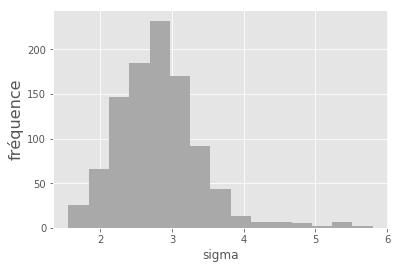

In [317]:
plt.style.use('ggplot')
#plt.figure(figsize=(10,5), dpi= 80)
_=plt.ylabel("fréquence", fontsize=16)  
_=plt.xlabel('sigma')

_=plt.hist(re_abc1.theta_list, 15,color="#A9A9A9")
plt.savefig(r'D:\3A\Hidden Markov Model\Projet\abc_sigma1_theta3_50p_1000.jpg')

plt.show()


In [365]:
#variance empirique du posteririeur
np.var(re_abc1.theta_list)
2.562**2 * np.var(re_abc1.theta_list)


0.41539049640205195

2.72655841746563

In [301]:
#scale= 2.25
fk2= fixed_RE_FK( eps_list1, Y)
re_abc2= RE_ABC(theta0= 3, prior= unif10, q= norm_pdf, q_ker= norm_kernel, refk= fk2, N=50, print_step=True)

In [308]:
%%time
re_abc2.run(2000)
#16 min 41 pour 1000

--------------------------
step: 1000, theta: 3.30830673137808, nb accepted: 377
proposal: -0.13541913463481237
previous: 3.30830673137808
>> ESS null: SMC aborted
>> Iteration failed
proposal: 1.5305014402788608
previous: 3.30830673137808


C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\particles-0.1-py3.7-win-amd64.egg\particles\resampling.py:158: RuntimeWarning: invalid value encountered in subtract
  w = np.exp(lw - lw.max())
C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\particles-0.1-py3.7-win-amd64.egg\particles\resampling.py:299: RuntimeWarning: invalid value encountered in subtract
  V = np.exp(v - m)


-------
L_prime:    0.0904096512
L_tp:       0.4325538239447038
prob ratio: 0.2090136445344607
u:          0.2858646339489439
>> Rejected

--------------------------
step: 1001, theta: 3.30830673137808, nb accepted: 377
proposal: 2.598292948546603
previous: 3.30830673137808
-------
L_prime:    0.7312896000000001
L_tp:       0.4325538239447038
prob ratio: 1.6906326092113932
u:          0.06227886759689105
>> Accepted

--------------------------
step: 1002, theta: 2.598292948546603, nb accepted: 378
proposal: -0.3890227988978987
previous: 2.598292948546603
>> ESS null: SMC aborted
>> Iteration failed
proposal: 2.2071260258625998
previous: 2.598292948546603
-------
L_prime:    0.5941039104000001
L_tp:       0.7312896000000001
prob ratio: 0.8124057971014493
u:          0.29431385250831565
>> Accepted

--------------------------
step: 1003, theta: 2.2071260258625998, nb accepted: 379
proposal: -0.8737722873783955
previous: 2.2071260258625998
>> ESS null: SMC aborted
>> Iteration failed
prop

-------
L_prime:    0.25381288979988487
L_tp:       0.574012309635072
prob ratio: 0.4421732522796354
u:          0.5703914900485199
>> Rejected

--------------------------
step: 1027, theta: 2.9984840896792737, nb accepted: 386
proposal: 2.977485360997846
previous: 2.9984840896792737
-------
L_prime:    0.6724684799999999
L_tp:       0.574012309635072
prob ratio: 1.1715227508405202
u:          0.5122880878723972
>> Accepted

--------------------------
step: 1028, theta: 2.977485360997846, nb accepted: 387
proposal: 2.8297129203590488
previous: 2.977485360997846
-------
L_prime:    0.598778820864
L_tp:       0.6724684799999999
prob ratio: 0.8904191626409018
u:          0.9892663113821344
>> Rejected

--------------------------
step: 1029, theta: 2.977485360997846, nb accepted: 387
proposal: 5.9333944436676695
previous: 2.977485360997846
-------
L_prime:    0.06798448450938911
L_tp:       0.6724684799999999
prob ratio: 0.10109690867501941
u:          0.1533519103400237
>> Rejected

-----

-------
L_prime:    0.7485155327999999
L_tp:       0.11780079632384
prob ratio: 6.3540787172804425
u:          0.08692944647458001
>> Accepted

--------------------------
step: 1056, theta: 2.641825096179076, nb accepted: 396
proposal: 6.472237288188841
previous: 2.641825096179076
-------
L_prime:    0.2743296
L_tp:       0.7485155327999999
prob ratio: 0.36649820608772815
u:          0.5581911316739483
>> Rejected

--------------------------
step: 1057, theta: 2.641825096179076, nb accepted: 396
proposal: 1.140525157495121
previous: 2.641825096179076
-------
L_prime:    0.044748800000000005
L_tp:       0.7485155327999999
prob ratio: 0.05978339531927481
u:          0.0645733622762743
>> Rejected

--------------------------
step: 1058, theta: 2.641825096179076, nb accepted: 396
proposal: 1.8189941309747464
previous: 2.641825096179076
-------
L_prime:    0.46521728
L_tp:       0.7485155327999999
prob ratio: 0.621519874490439
u:          0.8269702042798489
>> Rejected

--------------------

-------
L_prime:    0.268088
L_tp:       0.63786541056
prob ratio: 0.4202892891850618
u:          0.8425166165934018
>> Rejected

--------------------------
step: 1082, theta: 2.657278213852374, nb accepted: 408
proposal: 2.2772581479941048
previous: 2.657278213852374
-------
L_prime:    0.6532560831999998
L_tp:       0.63786541056
prob ratio: 1.0241284013605443
u:          0.6065257839762751
>> Accepted

--------------------------
step: 1083, theta: 2.2772581479941048, nb accepted: 409
proposal: 0.3125482117848286
previous: 2.2772581479941048
-------
L_prime:    0.22559999999999997
L_tp:       0.6532560831999998
prob ratio: 0.34534695627308937
u:          0.365689319570648
>> Rejected

--------------------------
step: 1084, theta: 2.2772581479941048, nb accepted: 409
proposal: 1.6544815926429446
previous: 2.2772581479941048
-------
L_prime:    0.073272815616
L_tp:       0.6532560831999998
prob ratio: 0.11216553125241531
u:          0.08054529246029296
>> Accepted

--------------------

-------
L_prime:    0.08611200000000001
L_tp:       0.5953711679999998
prob ratio: 0.14463582489100318
u:          0.5952880851031835
>> Rejected

--------------------------
step: 1110, theta: 2.2318661366394625, nb accepted: 422
proposal: 0.9323666777058321
previous: 2.2318661366394625
-------
L_prime:    0.22732799999999997
L_tp:       0.5953711679999998
prob ratio: 0.3818256781960931
u:          0.48338263141161275
>> Rejected

--------------------------
step: 1111, theta: 2.2318661366394625, nb accepted: 422
proposal: 2.52624804082009
previous: 2.2318661366394625
-------
L_prime:    0.6807077020799999
L_tp:       0.5953711679999998
prob ratio: 1.1433333333333333
u:          0.032529683433364265
>> Accepted

--------------------------
step: 1112, theta: 2.52624804082009, nb accepted: 423
proposal: 5.706081275606673
previous: 2.52624804082009
-------
L_prime:    0.43161395200000013
L_tp:       0.6807077020799999
prob ratio: 0.6340665026723539
u:          0.9088185775979748
>> Rejecte

-------
L_prime:    0.05299656796284128
L_tp:       0.2429582416029941
prob ratio: 0.21813035694191563
u:          0.28689118228347255
>> Rejected

--------------------------
step: 1137, theta: 3.606362693116463, nb accepted: 432
proposal: 2.8455447557984366
previous: 3.606362693116463
-------
L_prime:    0.76379136
L_tp:       0.2429582416029941
prob ratio: 3.143714553417263
u:          0.692862569201324
>> Accepted

--------------------------
step: 1138, theta: 2.8455447557984366, nb accepted: 433
proposal: -0.19106048347184634
previous: 2.8455447557984366
>> ESS null: SMC aborted
>> Iteration failed
proposal: 3.5488176136777687
previous: 2.8455447557984366
-------
L_prime:    0.4719987152584702
L_tp:       0.76379136
prob ratio: 0.6179681258223059
u:          0.631312697467627
>> Rejected

--------------------------
step: 1139, theta: 2.8455447557984366, nb accepted: 433
proposal: 4.777330922570107
previous: 2.8455447557984366
-------
L_prime:    0.54168846336
L_tp:       0.76379136

-------
L_prime:    0.4088876748042239
L_tp:       0.5264674652160001
prob ratio: 0.7766627604166664
u:          0.894224061679565
>> Rejected

--------------------------
step: 1166, theta: 3.1712755289668864, nb accepted: 441
proposal: 4.654831989379628
previous: 3.1712755289668864
-------
L_prime:    0.28175748762483815
L_tp:       0.5264674652160001
prob ratio: 0.5351849947826085
u:          0.5384552012434688
>> Rejected

--------------------------
step: 1167, theta: 3.1712755289668864, nb accepted: 441
proposal: 3.748306183825448
previous: 3.1712755289668864
-------
L_prime:    0.4573087845580801
L_tp:       0.5264674652160001
prob ratio: 0.8686363636363638
u:          0.9708078039897183
>> Rejected

--------------------------
step: 1168, theta: 3.1712755289668864, nb accepted: 441
proposal: 3.1853077767619062
previous: 3.1712755289668864
-------
L_prime:    0.5412743626751999
L_tp:       0.5264674652160001
prob ratio: 1.0281249999999997
u:          0.8182332458554988
>> Accepted


-------
L_prime:    0.7294737407999999
L_tp:       0.67329351857152
prob ratio: 1.0834409075371374
u:          0.3686245568566058
>> Accepted

--------------------------
step: 1191, theta: 2.7382281032775504, nb accepted: 451
proposal: 7.1889554990004765
previous: 2.7382281032775504
-------
L_prime:    0.12230399999999998
L_tp:       0.7294737407999999
prob ratio: 0.16766059305420852
u:          0.2826738292412899
>> Rejected

--------------------------
step: 1192, theta: 2.7382281032775504, nb accepted: 451
proposal: 1.716624849762534
previous: 2.7382281032775504
-------
L_prime:    0.4225759999999999
L_tp:       0.7294737407999999
prob ratio: 0.5792888439501178
u:          0.728802034450058
>> Rejected

--------------------------
step: 1193, theta: 2.7382281032775504, nb accepted: 451
proposal: -0.3906862389762771
previous: 2.7382281032775504
>> ESS null: SMC aborted
>> Iteration failed
proposal: 5.84710714992716
previous: 2.7382281032775504
-------
L_prime:    0.57470336
L_tp:      

-------
L_prime:    0.08982005760000002
L_tp:       0.57458294784
prob ratio: 0.15632217756836664
u:          0.24758216071743566
>> Rejected

--------------------------
step: 1218, theta: 3.082966448470603, nb accepted: 458
proposal: -0.8736569776165095
previous: 3.082966448470603
>> ESS null: SMC aborted
>> Iteration failed
proposal: 2.979844429517723
previous: 3.082966448470603
-------
L_prime:    0.6876721152
L_tp:       0.57458294784
prob ratio: 1.1968195676274949
u:          0.7010998434535392
>> Accepted

--------------------------
step: 1219, theta: 2.979844429517723, nb accepted: 459
proposal: 4.677823435851465
previous: 2.979844429517723
-------
L_prime:    0.41101398245376
L_tp:       0.6876721152
prob ratio: 0.5976888888888888
u:          0.7455403871671503
>> Rejected

--------------------------
step: 1220, theta: 2.979844429517723, nb accepted: 459
proposal: 0.7458361368713908
previous: 2.979844429517723
-------
L_prime:    0.084224
L_tp:       0.6876721152
prob ratio: 0.

-------
L_prime:    0.13148209063290467
L_tp:       0.7637484959999998
prob ratio: 0.17215364916791234
u:          0.24457444826437258
>> Rejected

--------------------------
step: 1247, theta: 2.690559823368968, nb accepted: 466
proposal: 1.9410278356097885
previous: 2.690559823368968
-------
L_prime:    0.35149015351296004
L_tp:       0.7637484959999998
prob ratio: 0.4602171465526004
u:          0.4038640777505663
>> Accepted

--------------------------
step: 1248, theta: 1.9410278356097885, nb accepted: 467
proposal: -2.955191161342764
previous: 1.9410278356097885
>> ESS null: SMC aborted
>> Iteration failed
proposal: 0.0693488552732
previous: 1.9410278356097885
>> ESS null: SMC aborted
>> Iteration failed
proposal: 3.092882755152209
previous: 1.9410278356097885
-------
L_prime:    0.5379442371381656
L_tp:       0.35149015351296004
prob ratio: 1.5304674448535605
u:          0.14974519450369705
>> Accepted

--------------------------
step: 1249, theta: 3.092882755152209, nb accepted:

-------
L_prime:    0.055453778913482944
L_tp:       0.5001375111118849
prob ratio: 0.11087706417021274
u:          0.13787702194773055
>> Rejected

--------------------------
step: 1275, theta: 3.162180608623605, nb accepted: 475
proposal: 4.514334157145528
previous: 3.162180608623605
-------
L_prime:    0.34261353024417784
L_tp:       0.5001375111118849
prob ratio: 0.6850386596328152
u:          0.8481116123734592
>> Rejected

--------------------------
step: 1276, theta: 3.162180608623605, nb accepted: 475
proposal: 0.5521737089446677
previous: 3.162180608623605
-------
L_prime:    0.0264
L_tp:       0.5001375111118849
prob ratio: 0.05278548281913232
u:          0.7623348766139209
>> Rejected

--------------------------
step: 1277, theta: 3.162180608623605, nb accepted: 475
proposal: 2.3840253062231933
previous: 3.162180608623605
-------
L_prime:    0.7166638080000001
L_tp:       0.5001375111118849
prob ratio: 1.4329335274347708
u:          0.8912942199999487
>> Accepted

----------

-------
L_prime:    0.19186180437757136
L_tp:       0.58766432256
prob ratio: 0.32648196770186344
u:          0.3785484399828113
>> Rejected

--------------------------
step: 1304, theta: 3.0379008593741634, nb accepted: 482
proposal: -0.24102772807026707
previous: 3.0379008593741634
>> ESS null: SMC aborted
>> Iteration failed
proposal: 1.4470995470594223
previous: 3.0379008593741634
-------
L_prime:    0.45007872
L_tp:       0.58766432256
prob ratio: 0.7658772239896311
u:          0.921453276248516
>> Rejected

--------------------------
step: 1305, theta: 3.0379008593741634, nb accepted: 482
proposal: 1.065808718916045
previous: 3.0379008593741634
-------
L_prime:    0.026598297599999998
L_tp:       0.58766432256
prob ratio: 0.04526103862172837
u:          0.17479149177679165
>> Rejected

--------------------------
step: 1306, theta: 3.0379008593741634, nb accepted: 482
proposal: 1.1566359232658117
previous: 3.0379008593741634
-------
L_prime:    0.374556
L_tp:       0.58766432256
p

-------
L_prime:    0.13478400000000001
L_tp:       0.3190456210292736
prob ratio: 0.42245995906533096
u:          0.7563418058318674
>> Rejected

--------------------------
step: 1332, theta: 3.3302775890059424, nb accepted: 492
proposal: 2.8477392372437476
previous: 3.3302775890059424
-------
L_prime:    0.6892066427903998
L_tp:       0.3190456210292736
prob ratio: 2.1602134533830903
u:          0.5914719669005928
>> Accepted

--------------------------
step: 1333, theta: 2.8477392372437476, nb accepted: 493
proposal: 0.8239059272396188
previous: 2.8477392372437476
-------
L_prime:    0.05992896
L_tp:       0.6892066427903998
prob ratio: 0.08695354379836628
u:          0.18483080076992653
>> Rejected

--------------------------
step: 1334, theta: 2.8477392372437476, nb accepted: 493
proposal: 0.15245858231714715
previous: 2.8477392372437476
>> ESS null: SMC aborted
>> Iteration failed
proposal: -2.0202064112020897
previous: 2.8477392372437476
>> ESS null: SMC aborted
>> Iteration fai

-------
L_prime:    0.00363197952
L_tp:       0.7023305318399999
prob ratio: 0.005171325117369968
u:          0.04845578776177817
>> Rejected

--------------------------
step: 1359, theta: 2.786667458659706, nb accepted: 501
proposal: 0.6051102734710825
previous: 2.786667458659706
-------
L_prime:    0.0792
L_tp:       0.7023305318399999
prob ratio: 0.11276741706288629
u:          0.22106595673959228
>> Rejected

--------------------------
step: 1360, theta: 2.786667458659706, nb accepted: 501
proposal: 4.721523636100056
previous: 2.786667458659706
-------
L_prime:    0.2563669427185152
L_tp:       0.7023305318399999
prob ratio: 0.36502320644792774
u:          0.42520470189579596
>> Rejected

--------------------------
step: 1361, theta: 2.786667458659706, nb accepted: 501
proposal: 2.704108901306605
previous: 2.786667458659706
-------
L_prime:    0.75012972281856
L_tp:       0.7023305318399999
prob ratio: 1.0680579710144928
u:          0.9583960364402476
>> Accepted

-----------------

-------
L_prime:    0.55297363968
L_tp:       0.08616376146476672
prob ratio: 6.417705428355944
u:          0.249481735369382
>> Accepted

--------------------------
step: 1388, theta: 3.1269753289232822, nb accepted: 508
proposal: 2.74715727168676
previous: 3.1269753289232822
-------
L_prime:    0.8124983999999998
L_tp:       0.55297363968
prob ratio: 1.4693257357985168
u:          0.24570745175723974
>> Accepted

--------------------------
step: 1389, theta: 2.74715727168676, nb accepted: 509
proposal: 1.4333129318499755
previous: 2.74715727168676
-------
L_prime:    0.15973984
L_tp:       0.8124983999999998
prob ratio: 0.19660326715720303
u:          0.3657294875841599
>> Rejected

--------------------------
step: 1390, theta: 2.74715727168676, nb accepted: 509
proposal: 2.944177671699919
previous: 2.74715727168676
-------
L_prime:    0.6174265742131201
L_tp:       0.8124983999999998
prob ratio: 0.759911126241135
u:          0.7566222997686326
>> Accepted

--------------------------

-------
L_prime:    0.7474118615039997
L_tp:       0.6683154186239999
prob ratio: 1.1183519647696474
u:          0.32885020363238904
>> Accepted

--------------------------
step: 1417, theta: 2.429170900913202, nb accepted: 520
proposal: 3.7583140260529264
previous: 2.429170900913202
-------
L_prime:    0.38740680675164163
L_tp:       0.7474118615039997
prob ratio: 0.5183310925412287
u:          0.5597701591990412
>> Rejected

--------------------------
step: 1418, theta: 2.429170900913202, nb accepted: 520
proposal: -1.3253380666867969
previous: 2.429170900913202
>> ESS null: SMC aborted
>> Iteration failed
proposal: 3.706042701740956
previous: 2.429170900913202
-------
L_prime:    0.4610626571206655
L_tp:       0.7474118615039997
prob ratio: 0.616878967097043
u:          0.6507982803207601
>> Rejected

--------------------------
step: 1419, theta: 2.429170900913202, nb accepted: 520
proposal: 3.211701569263839
previous: 2.429170900913202
-------
L_prime:    0.5080253547788696
L_tp:  

-------
L_prime:    0.05219565171641837
L_tp:       0.2366772919676928
prob ratio: 0.22053510618814776
u:          0.2623841779439836
>> Rejected

--------------------------
step: 1444, theta: 3.748717106735589, nb accepted: 529
proposal: 1.983385793550813
previous: 3.748717106735589
-------
L_prime:    0.39992279039999995
L_tp:       0.2366772919676928
prob ratio: 1.6897387454246802
u:          0.35714422549023683
>> Accepted

--------------------------
step: 1445, theta: 1.983385793550813, nb accepted: 530
proposal: 0.07695490474022115
previous: 1.983385793550813
>> ESS null: SMC aborted
>> Iteration failed
proposal: 1.5043506382579759
previous: 1.983385793550813
-------
L_prime:    0.025614876671999996
L_tp:       0.39992279039999995
prob ratio: 0.06404955478126209
u:          0.1175727475805729
>> Rejected

--------------------------
step: 1446, theta: 1.983385793550813, nb accepted: 530
proposal: 0.1472930530946035
previous: 1.983385793550813
>> ESS null: SMC aborted
>> Iteration 

-------
L_prime:    0.4473672892415999
L_tp:       0.757344
prob ratio: 0.5907055304347825
u:          0.09961191452734386
>> Accepted

--------------------------
step: 1471, theta: 3.0999578818220215, nb accepted: 538
proposal: 3.470107733182907
previous: 3.0999578818220215
-------
L_prime:    0.32721895755816954
L_tp:       0.4473672892415999
prob ratio: 0.7314324614857023
u:          0.7678663796792649
>> Rejected

--------------------------
step: 1472, theta: 3.0999578818220215, nb accepted: 538
proposal: 4.6277477662152915
previous: 3.0999578818220215
-------
L_prime:    0.11923976876283152
L_tp:       0.4473672892415999
prob ratio: 0.26653662802430844
u:          0.4534046409933098
>> Rejected

--------------------------
step: 1473, theta: 3.0999578818220215, nb accepted: 538
proposal: 0.43303707617976794
previous: 3.0999578818220215
-------
L_prime:    0.018000000000000002
L_tp:       0.4473672892415999
prob ratio: 0.040235395910404016
u:          0.65526080655009
>> Rejected

-

-------
L_prime:    0.6107222015999999
L_tp:       0.7321585582079998
prob ratio: 0.8341392649903289
u:          0.3619847961959336
>> Accepted

--------------------------
step: 1499, theta: 2.544505037854763, nb accepted: 547
proposal: 2.9427779896720425
previous: 2.544505037854763
-------
L_prime:    0.659293701696
L_tp:       0.6107222015999999
prob ratio: 1.07953125
u:          0.4253861157062736
>> Accepted

--------------------------
step: 1500, theta: 2.9427779896720425, nb accepted: 548
proposal: 1.1094871446971228
previous: 2.9427779896720425
-------
L_prime:    0.24837120000000001
L_tp:       0.659293701696
prob ratio: 0.37672314988157407
u:          0.8810851094674294
>> Rejected

--------------------------
step: 1501, theta: 2.9427779896720425, nb accepted: 548
proposal: 2.178230068324699
previous: 2.9427779896720425
-------
L_prime:    0.46003313663999995
L_tp:       0.659293701696
prob ratio: 0.6977666182106513
u:          0.06169587077494976
>> Accepted

----------------

-------
L_prime:    0.15847546319319855
L_tp:       0.5761718653824
prob ratio: 0.27504894409937886
u:          0.2996645449412815
>> Rejected

--------------------------
step: 1527, theta: 3.0536433933656784, nb accepted: 556
proposal: 4.97673391061647
previous: 3.0536433933656784
-------
L_prime:    0.16127088652745442
L_tp:       0.5761718653824
prob ratio: 0.2799006619672768
u:          0.41573050934012123
>> Rejected

--------------------------
step: 1528, theta: 3.0536433933656784, nb accepted: 556
proposal: 1.7804370380335144
previous: 3.0536433933656784
-------
L_prime:    0.297792
L_tp:       0.5761718653824
prob ratio: 0.5168457848985011
u:          0.8434377400316277
>> Rejected

--------------------------
step: 1529, theta: 3.0536433933656784, nb accepted: 556
proposal: 1.779755966682535
previous: 3.0536433933656784
-------
L_prime:    0.18356494464
L_tp:       0.5761718653824
prob ratio: 0.3185940787271341
u:          0.3140443324899239
>> Accepted

-----------------------

-------
L_prime:    0.6851222335999999
L_tp:       0.6539853788159998
prob ratio: 1.0476109341165571
u:          0.7133024062719318
>> Accepted

--------------------------
step: 1555, theta: 2.867134285616773, nb accepted: 564
proposal: 2.7951542023498512
previous: 2.867134285616773
-------
L_prime:    0.8312908799999998
L_tp:       0.6851222335999999
prob ratio: 1.2133468149646105
u:          0.458963327000678
>> Accepted

--------------------------
step: 1556, theta: 2.7951542023498512, nb accepted: 565
proposal: -0.14724368378954988
previous: 2.7951542023498512
>> ESS null: SMC aborted
>> Iteration failed
proposal: 2.4991373189147637
previous: 2.7951542023498512
-------
L_prime:    0.6730407935999999
L_tp:       0.8312908799999998
prob ratio: 0.8096333182435491
u:          0.3346454450417874
>> Accepted

--------------------------
step: 1557, theta: 2.4991373189147637, nb accepted: 566
proposal: 3.8737409295950758
previous: 2.4991373189147637
-------
L_prime:    0.25823254777285315


-------
L_prime:    0.009152
L_tp:       0.111492364032
prob ratio: 0.08208633909110796
u:          0.10334982016257577
>> Rejected

--------------------------
step: 1582, theta: 1.711961019463378, nb accepted: 579
proposal: -0.7289398570386845
previous: 1.711961019463378
>> ESS null: SMC aborted
>> Iteration failed
proposal: -0.4821867000218809
previous: 1.711961019463378
>> ESS null: SMC aborted
>> Iteration failed
proposal: 1.1480972101483937
previous: 1.711961019463378
-------
L_prime:    0.021270400000000005
L_tp:       0.111492364032
prob ratio: 0.1907789845939142
u:          0.9810275171505589
>> Rejected

--------------------------
step: 1583, theta: 1.711961019463378, nb accepted: 579
proposal: -0.16144080853305853
previous: 1.711961019463378
>> ESS null: SMC aborted
>> Iteration failed
proposal: 1.699688143465676
previous: 1.711961019463378
-------
L_prime:    0.09109565740154879
L_tp:       0.111492364032
prob ratio: 0.8170573670444637
u:          0.41712618028135107
>> Acce

-------
L_prime:    0.0392
L_tp:       0.39244004352
prob ratio: 0.09988786987279559
u:          0.14123223000533436
>> Rejected

--------------------------
step: 1609, theta: 1.9669876532047599, nb accepted: 586
proposal: -0.9650463788642509
previous: 1.9669876532047599
>> ESS null: SMC aborted
>> Iteration failed
proposal: -2.2353112304725853
previous: 1.9669876532047599
>> ESS null: SMC aborted
>> Iteration failed
proposal: 0.3865222903159662
previous: 1.9669876532047599
-------
L_prime:    0.0176
L_tp:       0.39244004352
prob ratio: 0.04484761504492864
u:          0.10243454972540145
>> Rejected

--------------------------
step: 1610, theta: 1.9669876532047599, nb accepted: 586
proposal: 3.8246412297335333
previous: 1.9669876532047599
-------
L_prime:    0.25643890447201856
L_tp:       0.39244004352
prob ratio: 0.6534473449036543
u:          0.7816491736031919
>> Rejected

--------------------------
step: 1611, theta: 1.9669876532047599, nb accepted: 586
proposal: 0.84423508496860

-------
L_prime:    0.43825600000000003
L_tp:       0.65436848160768
prob ratio: 0.66973885863707
u:          0.6788511654842205
>> Rejected

--------------------------
step: 1637, theta: 2.259163373553058, nb accepted: 594
proposal: 4.709108075796491
previous: 2.259163373553058
-------
L_prime:    0.22278898368302286
L_tp:       0.65436848160768
prob ratio: 0.34046411149825784
u:          0.40855686997587515
>> Rejected

--------------------------
step: 1638, theta: 2.259163373553058, nb accepted: 594
proposal: 0.2660006591642856
previous: 2.259163373553058
>> ESS null: SMC aborted
>> Iteration failed
proposal: 0.8844383544625327
previous: 2.259163373553058
-------
L_prime:    0.07002688
L_tp:       0.65436848160768
prob ratio: 0.10701444517614145
u:          0.3492924092384978
>> Rejected

--------------------------
step: 1639, theta: 2.259163373553058, nb accepted: 594
proposal: 3.2373226124910777
previous: 2.259163373553058
-------
L_prime:    0.47804462661795827
L_tp:       0.6543

-------
L_prime:    0.2325733456391889
L_tp:       0.7976639847679999
prob ratio: 0.29156806635419635
u:          0.29925174171893976
>> Rejected

--------------------------
step: 1665, theta: 2.8872714728664572, nb accepted: 606
proposal: 3.2382127522135975
previous: 2.8872714728664572
-------
L_prime:    0.5526196531199999
L_tp:       0.7976639847679999
prob ratio: 0.6927975484322876
u:          0.7393598843090814
>> Rejected

--------------------------
step: 1666, theta: 2.8872714728664572, nb accepted: 606
proposal: 1.8436002827383482
previous: 2.8872714728664572
-------
L_prime:    0.191215696896
L_tp:       0.7976639847679999
prob ratio: 0.23971960693651592
u:          0.031028576007839037
>> Accepted

--------------------------
step: 1667, theta: 1.8436002827383482, nb accepted: 607
proposal: -0.16080866895013113
previous: 1.8436002827383482
>> ESS null: SMC aborted
>> Iteration failed
proposal: 3.1963501129533447
previous: 1.8436002827383482
-------
L_prime:    0.49144872111103

-------
L_prime:    0.076608
L_tp:       0.6563872788479997
prob ratio: 0.1167115854750442
u:          0.2104005273877776
>> Rejected

--------------------------
step: 1693, theta: 2.499562923430501, nb accepted: 614
proposal: 3.873970699509795
previous: 2.499562923430501
-------
L_prime:    0.2601109105517828
L_tp:       0.6563872788479997
prob ratio: 0.39627658690810336
u:          0.4842803955405255
>> Rejected

--------------------------
step: 1694, theta: 2.499562923430501, nb accepted: 614
proposal: 0.2548585604509195
previous: 2.499562923430501
-------
L_prime:    0.013999999999999999
L_tp:       0.6563872788479997
prob ratio: 0.02132887161459141
u:          0.39107688719362543
>> Rejected

--------------------------
step: 1695, theta: 2.499562923430501, nb accepted: 614
proposal: 6.376498158311797
previous: 2.499562923430501
-------
L_prime:    0.38064768
L_tp:       0.6563872788479997
prob ratio: 0.5799132497937195
u:          0.5807316751919085
>> Rejected

------------------

-------
L_prime:    0.21187258776771933
L_tp:       0.71560710144
prob ratio: 0.2960739033212121
u:          0.147475625398527
>> Accepted

--------------------------
step: 1721, theta: 3.504909784565113, nb accepted: 620
proposal: 4.853739145257839
previous: 3.504909784565113
-------
L_prime:    0.008383098056817808
L_tp:       0.21187258776771933
prob ratio: 0.03956669498938855
u:          0.025020500737099716
>> Accepted

--------------------------
step: 1722, theta: 4.853739145257839, nb accepted: 621
proposal: 5.169358798655947
previous: 4.853739145257839
-------
L_prime:    0.004813656772626449
L_tp:       0.008383098056817808
prob ratio: 0.5742097658885903
u:          0.36419578079828385
>> Accepted

--------------------------
step: 1723, theta: 5.169358798655947, nb accepted: 622
proposal: 5.653172576783129
previous: 5.169358798655947
-------
L_prime:    0.0031830705131639637
L_tp:       0.004813656772626449
prob ratio: 0.6612583039291359
u:          0.7756427524266384
>> Rejec

-------
L_prime:    0.19930921365499432
L_tp:       0.53963413733376
prob ratio: 0.36934137384218696
u:          0.19395087045431236
>> Accepted

--------------------------
step: 1748, theta: 3.649018586525486, nb accepted: 636
proposal: 4.242926682191852
previous: 3.649018586525486
-------
L_prime:    0.06846265808045443
L_tp:       0.19930921365499432
prob ratio: 0.34349971496532905
u:          0.2764200263329576
>> Accepted

--------------------------
step: 1749, theta: 4.242926682191852, nb accepted: 637
proposal: 4.919461558241763
previous: 4.242926682191852
-------
L_prime:    0.04426522184515859
L_tp:       0.06846265808045443
prob ratio: 0.6465600823318891
u:          0.8828961267391022
>> Rejected

--------------------------
step: 1750, theta: 4.242926682191852, nb accepted: 637
proposal: 9.745449287317573
previous: 4.242926682191852
-------
L_prime:    0.06
L_tp:       0.06846265808045443
prob ratio: 0.8763901619111913
u:          0.9265792799967846
>> Rejected

-------------

-------
L_prime:    0.3217189270192128
L_tp:       0.35324121158516725
prob ratio: 0.9107627209619783
u:          0.9768696031285505
>> Rejected

--------------------------
step: 1776, theta: 3.4442995331842465, nb accepted: 647
proposal: 5.195615185126875
previous: 3.4442995331842465
-------
L_prime:    0.14694637762982707
L_tp:       0.35324121158516725
prob ratio: 0.41599443329504593
u:          0.42681469621174895
>> Rejected

--------------------------
step: 1777, theta: 3.4442995331842465, nb accepted: 647
proposal: 6.47052446009739
previous: 3.4442995331842465
-------
L_prime:    0.2156464128
L_tp:       0.35324121158516725
prob ratio: 0.6104792015413161
u:          0.8981984487827024
>> Rejected

--------------------------
step: 1778, theta: 3.4442995331842465, nb accepted: 647
proposal: 1.93950788503673
previous: 3.4442995331842465
-------
L_prime:    0.39222779903999994
L_tp:       0.35324121158516725
prob ratio: 1.1103681738602376
u:          0.23670404859002236
>> Accepted


-------
L_prime:    0.77832
L_tp:       0.3376822572359548
prob ratio: 2.304888644049043
u:          0.4854497376248882
>> Accepted

--------------------------
step: 1804, theta: 2.5274455456121077, nb accepted: 658
proposal: 0.47161541364192683
previous: 2.5274455456121077
-------
L_prime:    0.1568
L_tp:       0.77832
prob ratio: 0.20145955391098774
u:          0.8289245161598859
>> Rejected

--------------------------
step: 1805, theta: 2.5274455456121077, nb accepted: 658
proposal: 3.6249956690583627
previous: 2.5274455456121077
-------
L_prime:    0.321503816245248
L_tp:       0.77832
prob ratio: 0.4130740778153561
u:          0.45429538887357146
>> Rejected

--------------------------
step: 1806, theta: 2.5274455456121077, nb accepted: 658
proposal: 3.819091911968627
previous: 2.5274455456121077
-------
L_prime:    0.49574439936
L_tp:       0.77832
prob ratio: 0.6369416170212765
u:          0.8450748257163895
>> Rejected

--------------------------
step: 1807, theta: 2.5274455456

-------
L_prime:    0.013600000000000001
L_tp:       0.5453268172799999
prob ratio: 0.024939173297646642
u:          0.414568339417432
>> Rejected

--------------------------
step: 1832, theta: 3.0015189090311347, nb accepted: 668
proposal: 3.0328249925779387
previous: 3.0015189090311347
-------
L_prime:    0.526238963712
L_tp:       0.5453268172799999
prob ratio: 0.9649974052932018
u:          0.6597334536410671
>> Accepted

--------------------------
step: 1833, theta: 3.0328249925779387, nb accepted: 669
proposal: 1.396549663900453
previous: 3.0328249925779387
-------
L_prime:    0.448224
L_tp:       0.526238963712
prob ratio: 0.8517499290404197
u:          0.9259429574672927
>> Rejected

--------------------------
step: 1834, theta: 3.0328249925779387, nb accepted: 669
proposal: 7.305410943004376
previous: 3.0328249925779387
-------
L_prime:    0.3596
L_tp:       0.526238963712
prob ratio: 0.6833397463833595
u:          0.7378341448582488
>> Rejected

--------------------------
ste

-------
L_prime:    0.2765952
L_tp:       0.6410646950399999
prob ratio: 0.4314622254821591
u:          0.5294908518793172
>> Rejected

--------------------------
step: 1861, theta: 2.191874387071808, nb accepted: 680
proposal: -0.7673324172811204
previous: 2.191874387071808
>> ESS null: SMC aborted
>> Iteration failed
proposal: 8.413575556227652
previous: 2.191874387071808
-------
L_prime:    0.3
L_tp:       0.6410646950399999
prob ratio: 0.46797148918219733
u:          0.9192431845976877
>> Rejected

--------------------------
step: 1862, theta: 2.191874387071808, nb accepted: 680
proposal: 0.1445640401965691
previous: 2.191874387071808
>> ESS null: SMC aborted
>> Iteration failed
proposal: 2.019902772298696
previous: 2.191874387071808
-------
L_prime:    0.47076172185599985
L_tp:       0.6410646950399999
prob ratio: 0.7343435467564254
u:          0.3143736568439136
>> Accepted

--------------------------
step: 1863, theta: 2.019902772298696, nb accepted: 681
proposal: -0.53532211262

-------
L_prime:    0.020659139444735998
L_tp:       0.4807047767497113
prob ratio: 0.0429767716984693
u:          0.0700802162825025
>> Rejected

--------------------------
step: 1889, theta: 3.336890435860022, nb accepted: 691
proposal: 1.2728595891193293
previous: 3.336890435860022
-------
L_prime:    0.190464
L_tp:       0.4807047767497113
prob ratio: 0.3962182387448355
u:          0.5145252414839161
>> Rejected

--------------------------
step: 1890, theta: 3.336890435860022, nb accepted: 691
proposal: -1.5828253784275104
previous: 3.336890435860022
>> ESS null: SMC aborted
>> Iteration failed
proposal: 5.021447146642217
previous: 3.336890435860022
-------
L_prime:    0.07717030862363453
L_tp:       0.4807047767497113
prob ratio: 0.16053576406172226
u:          0.18840220864525026
>> Rejected

--------------------------
step: 1891, theta: 3.336890435860022, nb accepted: 691
proposal: 1.6044142815585745
previous: 3.336890435860022
-------
L_prime:    0.132376882176
L_tp:       0.48

-------
L_prime:    0.7294737407999999
L_tp:       0.5985469952000001
prob ratio: 1.2187409621131784
u:          0.05038236023136233
>> Accepted

--------------------------
step: 1916, theta: 2.557825543547155, nb accepted: 703
proposal: -0.6556997511216176
previous: 2.557825543547155
>> ESS null: SMC aborted
>> Iteration failed
proposal: 5.232544137644012
previous: 2.557825543547155
-------
L_prime:    0.42249928089600003
L_tp:       0.7294737407999999
prob ratio: 0.5791836734693878
u:          0.6036496720006307
>> Rejected

--------------------------
step: 1917, theta: 2.557825543547155, nb accepted: 703
proposal: 3.302816649537484
previous: 2.557825543547155
-------
L_prime:    0.45298571673599997
L_tp:       0.7294737407999999
prob ratio: 0.6209760425909494
u:          0.5366343866523264
>> Accepted

--------------------------
step: 1918, theta: 3.302816649537484, nb accepted: 704
proposal: 3.8993785178380214
previous: 3.302816649537484
-------
L_prime:    0.18612635430518776
L_tp

-------
L_prime:    0.021217885846021974
L_tp:       0.5652376575999999
prob ratio: 0.0375379905438593
u:          0.005043010557735039
>> Accepted

--------------------------
step: 1944, theta: 4.653327406747575, nb accepted: 718
proposal: 2.349698157684268
previous: 4.653327406747575
-------
L_prime:    0.599327708672
L_tp:       0.021217885846021974
prob ratio: 28.246344288083954
u:          0.9059936751257432
>> Accepted

--------------------------
step: 1945, theta: 2.349698157684268, nb accepted: 719
proposal: 1.8204925262680538
previous: 2.349698157684268
-------
L_prime:    0.24981944795136
L_tp:       0.599327708672
prob ratio: 0.4168328017152986
u:          0.3822083524653608
>> Accepted

--------------------------
step: 1946, theta: 1.8204925262680538, nb accepted: 720
proposal: 3.484998668395249
previous: 1.8204925262680538
-------
L_prime:    0.2933873378509345
L_tp:       0.24981944795136
prob ratio: 1.174397510909788
u:          0.5396070278117165
>> Accepted

----------

>> ESS null: SMC aborted
>> Iteration failed
proposal: 6.352120227137167
previous: 2.6599060648655395
-------
L_prime:    0.25807316480000003
L_tp:       0.7166235887999999
prob ratio: 0.3601237369706857
u:          0.5409796664104753
>> Rejected

--------------------------
step: 1972, theta: 2.6599060648655395, nb accepted: 728
proposal: 2.0789908422800183
previous: 2.6599060648655395
-------
L_prime:    0.445310438272
L_tp:       0.7166235887999999
prob ratio: 0.6214007538011428
u:          0.366110184224933
>> Accepted

--------------------------
step: 1973, theta: 2.0789908422800183, nb accepted: 729
proposal: 0.12347386717793851
previous: 2.0789908422800183
>> ESS null: SMC aborted
>> Iteration failed
proposal: 3.2958208985889956
previous: 2.0789908422800183
-------
L_prime:    0.4903021811466239
L_tp:       0.445310438272
prob ratio: 1.1010345570366857
u:          0.7606271099802026
>> Accepted

--------------------------
step: 1974, theta: 3.2958208985889956, nb accepted: 730
pr

-------
L_prime:    0.007904
L_tp:       0.18452972210946386
prob ratio: 0.042833208166385854
u:          0.4981976150512639
>> Rejected

Wall time: 17min 16s


In [358]:
re_abc2.__dict__

{'theta': 3.592154327716782,
 'L_tp': 0.18452972210946386,
 'theta_list': [3,
  3,
  3,
  3,
  3.813014596575347,
  3.813014596575347,
  2.7024897799769905,
  2.278649300116456,
  2.278649300116456,
  2.278649300116456,
  2.2973868166418536,
  3.212662790852905,
  3.212662790852905,
  3.212662790852905,
  1.8168301044978261,
  1.8168301044978261,
  1.8168301044978261,
  1.8168301044978261,
  2.776631637312166,
  4.249731949466736,
  4.327882596132475,
  4.327882596132475,
  4.327882596132475,
  4.327882596132475,
  1.7955908559349076,
  2.650100651128856,
  2.650100651128856,
  2.650100651128856,
  2.106919675974377,
  2.106919675974377,
  3.582829195532694,
  2.7520355696937697,
  2.7520355696937697,
  3.470507016512619,
  3.470507016512619,
  3.470507016512619,
  3.470507016512619,
  3.820728363039551,
  2.942252574809526,
  2.942252574809526,
  2.3038258918886854,
  3.509323013081441,
  3.23892096936763,
  3.23892096936763,
  3.23892096936763,
  3.23892096936763,
  3.41347426677701,

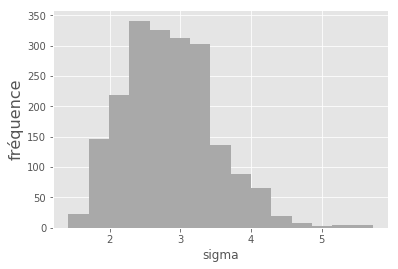

In [320]:
plt.style.use('ggplot')
#plt.figure(figsize=(10,5), dpi= 80)
_=plt.ylabel("fréquence", fontsize=16)  
_=plt.xlabel('sigma')

_=plt.hist(re_abc2.theta_list, 15,color="#A9A9A9")
plt.savefig(r'D:\3A\Hidden Markov Model\Projet\abc_sigma2.25_theta3_50p_1000.jpg.jpg')

plt.show()


In [310]:
np.var(re_abc2.theta_list)


0.4226738239038303

### tests SMC

#### qques petits run

In [252]:
fk1= fixed_RE_FK( eps_list= eps_list1, theta= 5, data=Y)
re_smc1= RE_SMC(fk=fk1, N=50)

In [253]:
re_smc1.run()

step: 0,  eps: 25.45,  P: 1.00e+00,  time: 0.02,  ESS: 50,  mean samp calls: 0.0
step: 1,  eps: 22.23,  P: 1.00e+00,  time: 0.05,  ESS: 50,  mean samp calls: 1.0
step: 2,  eps: 19.73,  P: 1.00e+00,  time: 0.05,  ESS: 50,  mean samp calls: 1.0
step: 3,  eps: 18.67,  P: 9.80e-01,  time: 0.05,  ESS: 49,  mean samp calls: 1.0
step: 4,  eps: 16.81,  P: 9.60e-01,  time: 0.04,  ESS: 49,  mean samp calls: 1.1


C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


step: 5,  eps: 15.56,  P: 8.84e-01,  time: 0.06,  ESS: 46,  mean samp calls: 1.1
step: 6,  eps: 13.87,  P: 7.42e-01,  time: 0.04,  ESS: 42,  mean samp calls: 1.2
step: 7,  eps: 12.51,  P: 5.64e-01,  time: 0.04,  ESS: 38,  mean samp calls: 1.4
step: 8,  eps: 11.63,  P: 5.19e-01,  time: 0.05,  ESS: 46,  mean samp calls: 1.4
step: 9,  eps: 10.76,  P: 3.84e-01,  time: 0.05,  ESS: 37,  mean samp calls: 1.9
step: 10,  eps: 10.14,  P: 3.23e-01,  time: 0.05,  ESS: 42,  mean samp calls: 1.7
step: 11,  eps: 9.36,  P: 2.32e-01,  time: 0.06,  ESS: 36,  mean samp calls: 2.7
step: 12,  eps: 8.38,  P: 1.44e-01,  time: 0.06,  ESS: 31,  mean samp calls: 2.9
step: 13,  eps: 7.82,  P: 1.18e-01,  time: 0.06,  ESS: 41,  mean samp calls: 2.8
step: 14,  eps: 7.16,  P: 8.50e-02,  time: 0.1,  ESS: 36,  mean samp calls: 3.1
step: 15,  eps: 6.69,  P: 6.80e-02,  time: 0.09,  ESS: 40,  mean samp calls: 3.4
step: 16,  eps: 6.28,  P: 5.31e-02,  time: 0.08,  ESS: 39,  mean samp calls: 2.9
step: 17,  eps: 5.92,  P: 3.

In [255]:
re_smc1.computation_time

1.2961268424987793

In [19]:
fk1= fixed_RE_FK( eps_list= eps_list1, theta= 5, data=Y, MK_name= 'random_walk', w=0.1)
re_smc1= RE_SMC(fk=fk1, N=50)

In [20]:
re_smc1.run()

step: 0,  eps: 25.62,  P: 1.00e+00,  time: 0.01,  ESS: 50,  mean samp calls: 0.0
step: 1,  eps: 22.06,  P: 1.00e+00,  time: 0.1,  ESS: 50,  mean samp calls: 7.0
step: 2,  eps: 18.94,  P: 9.60e-01,  time: 0.06,  ESS: 48,  mean samp calls: 5.8


C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


step: 3,  eps: 17.56,  P: 9.41e-01,  time: 0.07,  ESS: 49,  mean samp calls: 5.4
step: 4,  eps: 16.03,  P: 9.22e-01,  time: 0.07,  ESS: 49,  mean samp calls: 5.1
step: 5,  eps: 14.71,  P: 8.85e-01,  time: 0.09,  ESS: 48,  mean samp calls: 5.5
step: 6,  eps: 13.47,  P: 8.14e-01,  time: 0.07,  ESS: 46,  mean samp calls: 5.5
step: 7,  eps: 12.67,  P: 7.49e-01,  time: 0.05,  ESS: 46,  mean samp calls: 5.2
step: 8,  eps: 11.4,  P: 5.39e-01,  time: 0.08,  ESS: 36,  mean samp calls: 5.5
step: 9,  eps: 10.53,  P: 4.21e-01,  time: 0.06,  ESS: 39,  mean samp calls: 5.3
step: 10,  eps: 9.97,  P: 3.62e-01,  time: 0.06,  ESS: 43,  mean samp calls: 5.2
step: 11,  eps: 9.29,  P: 2.89e-01,  time: 0.05,  ESS: 40,  mean samp calls: 5.0
step: 12,  eps: 8.6,  P: 1.85e-01,  time: 0.06,  ESS: 32,  mean samp calls: 4.9
step: 13,  eps: 8.08,  P: 1.22e-01,  time: 0.1,  ESS: 33,  mean samp calls: 4.9
step: 14,  eps: 7.66,  P: 8.56e-02,  time: 0.09,  ESS: 35,  mean samp calls: 5.0
step: 15,  eps: 7.04,  P: 3.42e

C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\particles-0.1-py3.7-win-amd64.egg\particles\resampling.py:158: RuntimeWarning: invalid value encountered in subtract
  w = np.exp(lw - lw.max())
C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\particles-0.1-py3.7-win-amd64.egg\particles\resampling.py:299: RuntimeWarning: invalid value encountered in subtract
  V = np.exp(v - m)


## Graphiques

In [202]:
def sort_array(a):
    sa= np.empty(shape=(0,a.shape[1]))
    for i in range(a.shape[0]):
        s= np.sort(a[i])[np.newaxis,:]
        sa= np.append(sa, s, axis=0)
    return sa

In [397]:
def calc_P(N= 50, fktype='fixed',eps_list= eps_list1, MK_name= 'Slice_Sampling',
           theta0= 3, accept_rate=0.8, eps_target=2, T_max=200, w=1):
    
    def calc_fixed_P():
        fk1= fixed_RE_FK(eps_list= eps_list, MK_name= MK_name, theta= theta0, data=Y, w=w)
        re_smc1= RE_SMC(fk=fk1, N= N,print_step=False)
        re_smc1.run()
        if re_smc1.aborted:
            return np.inf
        return [re_smc1.computation_time, re_smc1.P]
        #return re_smc1.P

    def calc_adapt_P():
        fk1= adapt_RE_FK(T_max= T_max, accept_rate= accept_rate, MK_name= MK_name,
                         eps_target= eps_target, theta= theta0, data=Y,w=w)
        re_smc1= RE_SMC(fk=fk1, N=500, print_step=False)
        re_smc1.run()
        if re_smc1.aborted:
            return np.inf
        return [re_smc1.computation_time, re_smc1.P]
        #return re_smc1.P
    
    if fktype=='fixed':
        return calc_fixed_P
    if fktype=='adapt':
        return calc_adapt_P

In [259]:
from joblib import Parallel, delayed
import multiprocessing

### Convergence des particules

In [199]:
len(eps_list1)

21

In [237]:
fk1= fixed_RE_FK( eps_list= eps_list1, theta= 5, data=Y)
re_smc1= RE_SMC(fk=fk1, N=50)

In [247]:
fk1= fixed_RE_FK( eps_list= eps_list1, theta= 5, data=Y, MK_name= 'random_walk', w=0.01)
re_smc1= RE_SMC(fk=fk1, N=50)

In [248]:
X_q=np.empty(shape=(0,50))
while True:
    next(re_smc1)
    X_q= np.append(X_q, sort_array(re_smc1.X)[:,10][np.newaxis,:], axis=0)


step: 0,  eps: 25.45,  P: 1.00e+00,  time: 0.01,  ESS: 50,  mean samp calls: 0.0
step: 1,  eps: 22.23,  P: 1.00e+00,  time: 0.04,  ESS: 50,  mean samp calls: 1.2
step: 2,  eps: 19.73,  P: 9.60e-01,  time: 0.04,  ESS: 48,  mean samp calls: 1.1
step: 3,  eps: 18.67,  P: 9.41e-01,  time: 0.04,  ESS: 49,  mean samp calls: 1.2
step: 4,  eps: 16.81,  P: 9.22e-01,  time: 0.03,  ESS: 49,  mean samp calls: 1.2
step: 5,  eps: 15.56,  P: 8.67e-01,  time: 0.03,  ESS: 47,  mean samp calls: 1.2


C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


step: 6,  eps: 13.87,  P: 7.45e-01,  time: 0.05,  ESS: 43,  mean samp calls: 1.2
step: 7,  eps: 12.51,  P: 5.07e-01,  time: 0.04,  ESS: 34,  mean samp calls: 1.3
step: 8,  eps: 11.63,  P: 4.26e-01,  time: 0.03,  ESS: 42,  mean samp calls: 1.2
step: 9,  eps: 10.76,  P: 3.66e-01,  time: 0.03,  ESS: 43,  mean samp calls: 1.2
step: 10,  eps: 10.14,  P: 2.93e-01,  time: 0.03,  ESS: 40,  mean samp calls: 1.2
step: 11,  eps: 9.36,  P: 1.76e-01,  time: 0.03,  ESS: 30,  mean samp calls: 1.2
step: 12,  eps: 8.38,  P: 9.49e-02,  time: 0.03,  ESS: 27,  mean samp calls: 1.2
step: 13,  eps: 7.82,  P: 5.88e-02,  time: 0.03,  ESS: 31,  mean samp calls: 1.2
step: 14,  eps: 7.16,  P: 4.71e-02,  time: 0.03,  ESS: 40,  mean samp calls: 1.2
step: 15,  eps: 6.69,  P: 2.82e-02,  time: 0.03,  ESS: 30,  mean samp calls: 1.2
step: 16,  eps: 6.28,  P: 2.43e-02,  time: 0.03,  ESS: 43,  mean samp calls: 1.2
step: 17,  eps: 5.92,  P: 2.04e-02,  time: 0.03,  ESS: 42,  mean samp calls: 1.2
step: 18,  eps: 5.52,  P: 1

StopIteration: 

(array([ 2.,  1.,  6., 12., 11.,  5.,  4.,  6.,  1.,  2.]),
 array([0.20922109, 0.25239924, 0.29557738, 0.33875553, 0.38193368,
        0.42511183, 0.46828997, 0.51146812, 0.55464627, 0.59782442,
        0.64100256]),
 <a list of 10 Patch objects>)

(array([ 1.,  4.,  2.,  3.,  4., 13.,  3.,  5.,  9.,  6.]),
 array([0.46233442, 0.4692771 , 0.47621978, 0.48316246, 0.49010514,
        0.49704782, 0.5039905 , 0.51093318, 0.51787586, 0.52481854,
        0.53176122]),
 <a list of 10 Patch objects>)

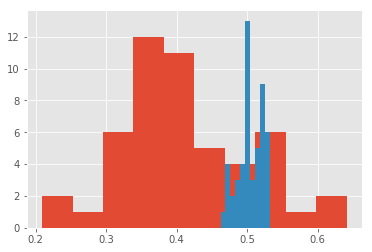

In [249]:
plt.style.use('ggplot')
plt.hist(X_q[0])
plt.hist(X_q[-1])

In [250]:
X_q.shape
len(eps_list1)
X_q_mean= np.nanmean(X_q, axis=1)
X_q_95= np.nanquantile(X_q, q=0.95, axis=1)
X_q_05= np.nanquantile(X_q, q=0.05, axis=1)

X_q_mean
X_q_95
X_q_05

(21, 50)

21

array([0.4110633 , 0.41084317, 0.41122863, 0.40876781, 0.40338128,
       0.39867497, 0.40043379, 0.41287313, 0.41983888, 0.42564199,
       0.42936735, 0.43115468, 0.43525776, 0.46465786, 0.5054712 ,
       0.51716956, 0.52666121, 0.52045727, 0.51340157, 0.50705309,
       0.50419499])

array([0.55880172, 0.55324025, 0.55667481, 0.54785116, 0.53222788,
       0.52881011, 0.51879999, 0.52606271, 0.52237409, 0.52307675,
       0.53283506, 0.53187717, 0.54754939, 0.56114828, 0.55922141,
       0.55630471, 0.55258075, 0.54755324, 0.53820948, 0.5278684 ,
       0.5282859 ])

array([0.2850092 , 0.28362786, 0.2790137 , 0.29310343, 0.28783038,
       0.28327379, 0.27986509, 0.32103484, 0.33871559, 0.33846026,
       0.33732859, 0.33859408, 0.32658798, 0.3606434 , 0.3645325 ,
       0.40279479, 0.49791119, 0.47947816, 0.48327467, 0.46894791,
       0.47230674])

<Figure size 800x400 with 0 Axes>

Text(0,0.5,'particules')

Text(0.5,0,'epsilon')

([<matplotlib.axis.XTick at 0x1855d3f4710>,
 <a list of 10 Text xticklabel objects>)

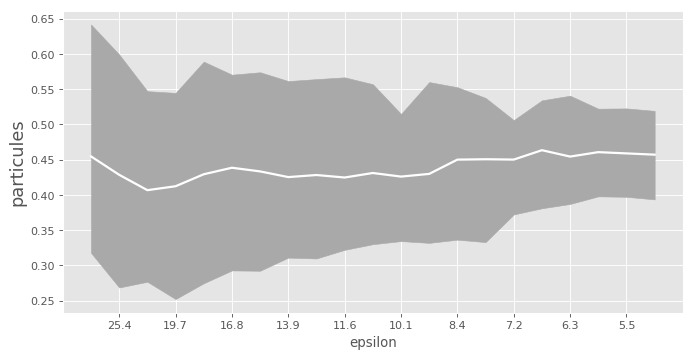

In [241]:
#eps = 5, 50 particules
plt.style.use('ggplot')
plt.figure(figsize=(10,5), dpi= 80)
plt.ylabel("particules", fontsize=16)  
plt.xlabel('epsilon')
x= np.arange(len(eps_list1))
plt.plot(x, X_q_mean, color="white", lw=2) 

plt.fill_between(x, X_q_95, X_q_05, color="#A9A9A9")  
plt.xticks(x[1::2], np.round(np.array(eps_list1)[x[1::2]-1],1))
plt.savefig(r'D:\3A\Hidden Markov Model\Projet\particules_10_smc_eps5_50p_theta5_fixed_ss.jpg')
plt.show()


<Figure size 800x400 with 0 Axes>

Text(0,0.5,'particules')

Text(0.5,0,'epsilon')

([<matplotlib.axis.XTick at 0x1855d6037b8>,
 <a list of 10 Text xticklabel objects>)

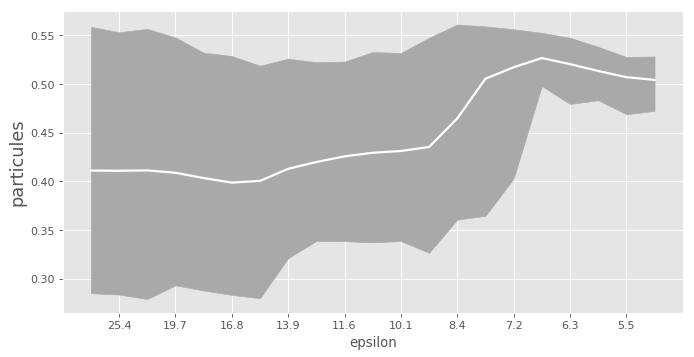

In [251]:
# random walk, eps = 5, 50 particules
plt.style.use('ggplot')
plt.figure(figsize=(10,5), dpi= 80)
plt.ylabel("particules", fontsize=16)  
plt.xlabel('epsilon')
x= np.arange(len(eps_list1))
plt.plot(x, X_q_mean, color="white", lw=2) 

plt.fill_between(x, X_q_95, X_q_05, color="#A9A9A9")  
plt.xticks(x[1::2], np.round(np.array(eps_list1)[x[1::2]-1],1))
plt.savefig(r'D:\3A\Hidden Markov Model\Projet\particules_10_smc_eps5_50p_theta5_fixed_rd.jpg')
plt.show()


### Calculs pour graphes de la variance fonction des particules

In [27]:
calc_P(50, theta0=5, MK_name= 'random_walk',w=0.1)()

C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


>> ESS null: SMC aborted


C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\particles-0.1-py3.7-win-amd64.egg\particles\resampling.py:158: RuntimeWarning: invalid value encountered in subtract
  w = np.exp(lw - lw.max())
C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\particles-0.1-py3.7-win-amd64.egg\particles\resampling.py:299: RuntimeWarning: invalid value encountered in subtract
  V = np.exp(v - m)


inf

In [247]:
results0 = Parallel(n_jobs=8)(delayed(calc_P(50))() for i in range(10))

In [260]:
#results for diff values of N
#0 fixed fk

results_list= []
for eps_target in [5, 8, 10]:
    for N in np.arange(10, 101, 10):
        print(N)

        fk1= adapt_RE_FK(200, 0.5, eps_target=eps_target, theta= 5, data=Y)
        re_smc1= RE_SMC(fk=fk1, N=N)
        re_smc1.run()
        eps_list1= re_smc1.fk.eps_list

        results0 = Parallel(n_jobs=8)(delayed(calc_P(N, 'fixed', eps_list1))() for i in range(200))
        results_list.append((eps_target, N, 'ss', results0))

10
step: 0,  eps: 13.36,  P: 5.00e-01,  time: 0.01,  ESS: 5,  mean samp calls: 0.0
step: 1,  eps: 10.96,  P: 2.50e-01,  time: 0.01,  ESS: 5,  mean samp calls: 1.5
step: 2,  eps: 9.07,  P: 1.25e-01,  time: 0.02,  ESS: 5,  mean samp calls: 2.5
step: 3,  eps: 7.55,  P: 6.25e-02,  time: 0.03,  ESS: 5,  mean samp calls: 1.9
step: 4,  eps: 6.78,  P: 3.12e-02,  time: 0.02,  ESS: 5,  mean samp calls: 1.3
step: 5,  eps: 5.36,  P: 1.56e-02,  time: 0.02,  ESS: 5,  mean samp calls: 2.3
step: 6,  eps: 5,  P: 1.41e-02,  time: 0.02,  ESS: 9,  mean samp calls: 1.7


C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log


20
step: 0,  eps: 12.43,  P: 5.00e-01,  time: 0.01,  ESS: 10,  mean samp calls: 0.0
step: 1,  eps: 9.79,  P: 2.50e-01,  time: 0.02,  ESS: 10,  mean samp calls: 1.6
step: 2,  eps: 7.8,  P: 1.25e-01,  time: 0.02,  ESS: 10,  mean samp calls: 2.6
step: 3,  eps: 6.58,  P: 6.25e-02,  time: 0.03,  ESS: 10,  mean samp calls: 3.1
step: 4,  eps: 6.01,  P: 3.12e-02,  time: 0.03,  ESS: 10,  mean samp calls: 4.1
step: 5,  eps: 5.46,  P: 1.56e-02,  time: 0.03,  ESS: 10,  mean samp calls: 3.0
step: 6,  eps: 5.08,  P: 7.81e-03,  time: 0.02,  ESS: 10,  mean samp calls: 2.7
step: 7,  eps: 5,  P: 7.03e-03,  time: 0.02,  ESS: 18,  mean samp calls: 2.3
30
step: 0,  eps: 12.81,  P: 5.00e-01,  time: 0.01,  ESS: 15,  mean samp calls: 0.0
step: 1,  eps: 10.39,  P: 2.50e-01,  time: 0.05,  ESS: 15,  mean samp calls: 1.5
step: 2,  eps: 8.33,  P: 1.25e-01,  time: 0.05,  ESS: 15,  mean samp calls: 1.9
step: 3,  eps: 7.42,  P: 6.25e-02,  time: 0.05,  ESS: 15,  mean samp calls: 2.9
step: 4,  eps: 6.47,  P: 3.12e-02, 

step: 3,  eps: 8,  P: 9.38e-02,  time: 0.12,  ESS: 60,  mean samp calls: 3.0
90
step: 0,  eps: 11.76,  P: 5.00e-01,  time: 0.02,  ESS: 45,  mean samp calls: 0.0
step: 1,  eps: 9.36,  P: 2.50e-01,  time: 0.1,  ESS: 45,  mean samp calls: 1.8
step: 2,  eps: 8.39,  P: 1.25e-01,  time: 0.13,  ESS: 45,  mean samp calls: 2.6
step: 3,  eps: 8,  P: 1.03e-01,  time: 0.13,  ESS: 74,  mean samp calls: 3.3
100
step: 0,  eps: 12.19,  P: 5.00e-01,  time: 0.04,  ESS: 50,  mean samp calls: 0.0
step: 1,  eps: 9.83,  P: 2.50e-01,  time: 0.18,  ESS: 50,  mean samp calls: 1.7
step: 2,  eps: 8.28,  P: 1.25e-01,  time: 0.13,  ESS: 50,  mean samp calls: 2.4
step: 3,  eps: 8,  P: 1.02e-01,  time: 0.2,  ESS: 82,  mean samp calls: 2.8
10
step: 0,  eps: 11.46,  P: 5.00e-01,  time: 0.0,  ESS: 5,  mean samp calls: 0.0
step: 1,  eps: 10,  P: 3.50e-01,  time: 0.02,  ESS: 7,  mean samp calls: 1.9
20
step: 0,  eps: 13.2,  P: 5.00e-01,  time: 0.01,  ESS: 10,  mean samp calls: 0.0
step: 1,  eps: 11.16,  P: 2.50e-01,  tim

In [261]:
results0

[[0.12901806831359863, 0.99],
 [0.2650318145751953, 1.0],
 [0.31005072593688965, 0.99],
 [0.21002411842346191, 0.99],
 [0.2230229377746582, 1.0],
 [0.24002671241760254, 1.0],
 [0.21802663803100586, 1.0],
 [0.21202564239501953, 1.0],
 [0.2060236930847168, 0.99],
 [0.21802353858947754, 1.0],
 [0.21302127838134766, 0.99],
 [0.20201969146728516, 1.0],
 [0.20202136039733887, 0.99],
 [0.21602344512939453, 1.0],
 [0.2400202751159668, 1.0],
 [0.2300245761871338, 0.99],
 [0.21300458908081055, 1.0],
 [0.19802045822143555, 0.99],
 [0.20602083206176758, 1.0],
 [0.19402146339416504, 0.99],
 [0.2210233211517334, 1.0],
 [0.19801950454711914, 1.0],
 [0.24002456665039062, 1.0],
 [0.24802398681640625, 0.99],
 [0.21403861045837402, 1.0],
 [0.21602869033813477, 1.0],
 [0.23502326011657715, 1.0],
 [0.25403690338134766, 1.0],
 [0.1950209140777588, 1.0],
 [0.22802042961120605, 1.0],
 [0.20202136039733887, 1.0],
 [0.32503199577331543, 1.0],
 [0.23002386093139648, 1.0],
 [0.22402429580688477, 0.99],
 [0.261028

In [ ]:
import pickle
 
with open(r'D:\3A\Hidden Markov Model\Projet\results_list_fixed_ss', 'wb') as file:
    pickle.dump(results_list, file)

In [21]:
#results for diff values of N
#0 fixed fk
theta0= 3
results_list1= []
for eps_target in [5, 8, 10]:
    for N in np.arange(10, 101, 10):
        print(N)

        fk1= adapt_RE_FK(200, 0.5, eps_target=eps_target, theta= 8, data=Y)
        re_smc1= RE_SMC(fk=fk1, N=N)
        re_smc1.run()
        eps_list1= re_smc1.fk.eps_list

        results0 = Parallel(n_jobs=8)(delayed(calc_P(N, 'fixed', eps_list1, MK_name= 'random_walk', w=0.1))() 
                                      for i in range(200))
        results_list1.append((eps_target, N, 'rd', results0))

10
step: 0,  eps: 24.71,  P: 5.00e-01,  time: 0.0,  ESS: 5,  mean samp calls: 0.0
step: 1,  eps: 18.72,  P: 2.50e-01,  time: 0.02,  ESS: 5,  mean samp calls: 2.2
step: 2,  eps: 17.16,  P: 1.25e-01,  time: 0.02,  ESS: 5,  mean samp calls: 3.3
step: 3,  eps: 16.26,  P: 6.25e-02,  time: 0.03,  ESS: 5,  mean samp calls: 3.9
step: 4,  eps: 15.68,  P: 3.12e-02,  time: 0.02,  ESS: 5,  mean samp calls: 1.8
step: 5,  eps: 14.3,  P: 1.56e-02,  time: 0.01,  ESS: 5,  mean samp calls: 1.6
step: 6,  eps: 12.21,  P: 7.81e-03,  time: 0.01,  ESS: 5,  mean samp calls: 1.4
step: 7,  eps: 11.63,  P: 3.91e-03,  time: 0.02,  ESS: 5,  mean samp calls: 1.8
step: 8,  eps: 10.17,  P: 1.95e-03,  time: 0.02,  ESS: 5,  mean samp calls: 2.4
step: 9,  eps: 9.6,  P: 9.77e-04,  time: 0.02,  ESS: 5,  mean samp calls: 2.5
step: 10,  eps: 9.22,  P: 4.88e-04,  time: 0.01,  ESS: 5,  mean samp calls: 1.4
step: 11,  eps: 9.02,  P: 2.44e-04,  time: 0.02,  ESS: 5,  mean samp calls: 1.9

C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log



step: 12,  eps: 8.86,  P: 1.22e-04,  time: 0.02,  ESS: 5,  mean samp calls: 1.6
step: 13,  eps: 8.71,  P: 6.10e-05,  time: 0.01,  ESS: 5,  mean samp calls: 1.2
step: 14,  eps: 8.58,  P: 3.05e-05,  time: 0.01,  ESS: 5,  mean samp calls: 2.0
step: 15,  eps: 8.45,  P: 1.53e-05,  time: 0.01,  ESS: 5,  mean samp calls: 2.5
step: 16,  eps: 7.86,  P: 7.63e-06,  time: 0.01,  ESS: 5,  mean samp calls: 1.5
step: 17,  eps: 7.58,  P: 3.81e-06,  time: 0.02,  ESS: 5,  mean samp calls: 2.0
step: 18,  eps: 7.13,  P: 1.91e-06,  time: 0.01,  ESS: 5,  mean samp calls: 1.9
step: 19,  eps: 6.82,  P: 9.54e-07,  time: 0.01,  ESS: 5,  mean samp calls: 2.0
step: 20,  eps: 6.7,  P: 4.77e-07,  time: 0.02,  ESS: 5,  mean samp calls: 2.9
step: 21,  eps: 6.36,  P: 2.38e-07,  time: 0.01,  ESS: 5,  mean samp calls: 1.4
step: 22,  eps: 6.12,  P: 1.19e-07,  time: 0.01,  ESS: 5,  mean samp calls: 2.2
step: 23,  eps: 6.01,  P: 5.96e-08,  time: 0.02,  ESS: 5,  mean samp calls: 1.8
step: 24,  eps: 5.78,  P: 2.98e-08,  tim

step: 3,  eps: 19.29,  P: 6.25e-02,  time: 0.08,  ESS: 30,  mean samp calls: 2.6
step: 4,  eps: 17.77,  P: 3.12e-02,  time: 0.1,  ESS: 30,  mean samp calls: 3.2
step: 5,  eps: 15.96,  P: 1.56e-02,  time: 0.1,  ESS: 30,  mean samp calls: 3.3
step: 6,  eps: 14.89,  P: 7.81e-03,  time: 0.09,  ESS: 30,  mean samp calls: 3.1
step: 7,  eps: 13.55,  P: 3.91e-03,  time: 0.08,  ESS: 30,  mean samp calls: 3.1
step: 8,  eps: 12.65,  P: 1.95e-03,  time: 0.09,  ESS: 30,  mean samp calls: 3.6
step: 9,  eps: 11.92,  P: 9.77e-04,  time: 0.1,  ESS: 30,  mean samp calls: 3.7
step: 10,  eps: 11.06,  P: 4.88e-04,  time: 0.09,  ESS: 30,  mean samp calls: 3.1
step: 11,  eps: 10.45,  P: 2.44e-04,  time: 0.09,  ESS: 30,  mean samp calls: 2.5
step: 12,  eps: 9.81,  P: 1.22e-04,  time: 0.08,  ESS: 30,  mean samp calls: 2.7
step: 13,  eps: 8.86,  P: 6.10e-05,  time: 0.07,  ESS: 30,  mean samp calls: 2.5
step: 14,  eps: 8.04,  P: 3.05e-05,  time: 0.08,  ESS: 30,  mean samp calls: 2.1
step: 15,  eps: 7.23,  P: 1.5

10
step: 0,  eps: 26.15,  P: 5.00e-01,  time: 0.0,  ESS: 5,  mean samp calls: 0.0
step: 1,  eps: 23.84,  P: 2.50e-01,  time: 0.02,  ESS: 5,  mean samp calls: 2.2
step: 2,  eps: 20.18,  P: 1.25e-01,  time: 0.02,  ESS: 5,  mean samp calls: 2.3
step: 3,  eps: 18.23,  P: 6.25e-02,  time: 0.02,  ESS: 5,  mean samp calls: 2.9
step: 4,  eps: 16.13,  P: 3.12e-02,  time: 0.02,  ESS: 5,  mean samp calls: 2.0
step: 5,  eps: 13.51,  P: 1.56e-02,  time: 0.02,  ESS: 5,  mean samp calls: 2.6
step: 6,  eps: 12.13,  P: 7.81e-03,  time: 0.02,  ESS: 5,  mean samp calls: 2.0
step: 7,  eps: 11.22,  P: 3.91e-03,  time: 0.02,  ESS: 5,  mean samp calls: 1.8
step: 8,  eps: 10.36,  P: 1.95e-03,  time: 0.02,  ESS: 5,  mean samp calls: 2.6
step: 9,  eps: 9.94,  P: 9.77e-04,  time: 0.02,  ESS: 5,  mean samp calls: 2.1
step: 10,  eps: 9.61,  P: 4.88e-04,  time: 0.01,  ESS: 5,  mean samp calls: 1.4
step: 11,  eps: 8.35,  P: 2.44e-04,  time: 0.02,  ESS: 5,  mean samp calls: 1.8
step: 12,  eps: 8.05,  P: 1.22e-04,  ti

step: 11,  eps: 8.05,  P: 2.44e-04,  time: 0.11,  ESS: 35,  mean samp calls: 2.4
step: 12,  eps: 8,  P: 2.30e-04,  time: 0.08,  ESS: 66,  mean samp calls: 2.6
80
step: 0,  eps: 25.86,  P: 5.00e-01,  time: 0.02,  ESS: 40,  mean samp calls: 0.0
step: 1,  eps: 22.33,  P: 2.50e-01,  time: 0.1,  ESS: 40,  mean samp calls: 1.8
step: 2,  eps: 19.63,  P: 1.25e-01,  time: 0.09,  ESS: 40,  mean samp calls: 2.4
step: 3,  eps: 17.92,  P: 6.25e-02,  time: 0.12,  ESS: 40,  mean samp calls: 3.4
step: 4,  eps: 16.5,  P: 3.12e-02,  time: 0.1,  ESS: 40,  mean samp calls: 3.0
step: 5,  eps: 15.51,  P: 1.56e-02,  time: 0.1,  ESS: 40,  mean samp calls: 3.5
step: 6,  eps: 14.13,  P: 7.81e-03,  time: 0.1,  ESS: 40,  mean samp calls: 3.2
step: 7,  eps: 12.29,  P: 3.91e-03,  time: 0.09,  ESS: 40,  mean samp calls: 2.4
step: 8,  eps: 11.11,  P: 1.95e-03,  time: 0.09,  ESS: 40,  mean samp calls: 2.4
step: 9,  eps: 10.24,  P: 9.77e-04,  time: 0.1,  ESS: 40,  mean samp calls: 2.9
step: 10,  eps: 9.14,  P: 4.88e-04

step: 6,  eps: 13.29,  P: 7.81e-03,  time: 0.13,  ESS: 30,  mean samp calls: 4.0
step: 7,  eps: 12.21,  P: 3.91e-03,  time: 0.12,  ESS: 30,  mean samp calls: 3.9
step: 8,  eps: 10.87,  P: 1.95e-03,  time: 0.11,  ESS: 30,  mean samp calls: 2.8
step: 9,  eps: 10,  P: 1.14e-03,  time: 0.09,  ESS: 35,  mean samp calls: 2.2
70
step: 0,  eps: 25.32,  P: 5.00e-01,  time: 0.02,  ESS: 35,  mean samp calls: 0.0
step: 1,  eps: 22.26,  P: 2.50e-01,  time: 0.08,  ESS: 35,  mean samp calls: 1.8
step: 2,  eps: 20.36,  P: 1.25e-01,  time: 0.08,  ESS: 35,  mean samp calls: 2.6
step: 3,  eps: 18.43,  P: 6.25e-02,  time: 0.09,  ESS: 35,  mean samp calls: 3.4
step: 4,  eps: 17.27,  P: 3.12e-02,  time: 0.09,  ESS: 35,  mean samp calls: 3.2
step: 5,  eps: 15.97,  P: 1.56e-02,  time: 0.08,  ESS: 35,  mean samp calls: 2.9
step: 6,  eps: 14.65,  P: 7.81e-03,  time: 0.12,  ESS: 35,  mean samp calls: 3.9
step: 7,  eps: 13.61,  P: 3.91e-03,  time: 0.09,  ESS: 35,  mean samp calls: 3.6
step: 8,  eps: 12.75,  P: 1.

In [22]:
import pickle
 
with open(r'D:\3A\Hidden Markov Model\Projet\results_list_fixed_rw', 'wb') as file:
    pickle.dump(results_list1, file)

In [107]:
def log_distrib(a):
    return np.log(np.array(a))

In [324]:
#lecture des données
import pickle
with open(r'D:\3A\Hidden Markov Model\Projet\results_list_fixed_ss', 'rb') as f:
    results_list = pickle.load(f)

with open(r'D:\3A\Hidden Markov Model\Projet\results_list_fixed_rw', 'rb') as f:
    results_list1 = pickle.load(f)

In [355]:
import pandas as pd

pd_results= pd.DataFrame(results_list, columns= ['eps', 'nb_particules', 'fktype', 'distrib'])
pd_results= pd_results.append(pd.DataFrame(results_list1, columns= ['eps', 'nb_particules', 'fktype', 'distrib']))
pd_results= pd_results.reset_index(drop=True)

pd_results.loc[30:39, 'eps']=5#corrections
pd_results.loc[40:49, 'eps']=8
pd_results.loc[50:59, 'eps']=10

#pd_results['distrib']= pd_results['distrib'].apply(np.asarray)
#pd_results['log_distrib']=pd_results['distrib'].apply(np.log)
pd_results['log_distrib']=pd_results['distrib'].apply(log_distrib)

pd_results['var']= pd_results['distrib'].apply(np.var)
#pd_results['var']= pd_results['log_distrib'].apply(np.var)
#pd_results['var']= pd_results['log_distrib'].apply(np.var)/pd_results['log_distrib'].apply(np.mean)


pd_results=pd_results.drop(['distrib', 'log_distrib'], axis=1).set_index(['nb_particules','eps', 'fktype']).unstack().unstack()

pd_results.columns= pd_results.columns.get_level_values(0)+'_'+pd_results.columns.get_level_values(1)+'_'+ \
    pd_results.columns.get_level_values(2).astype(str)

pd_results

,var_rd_5,var_rd_8,var_rd_10,var_ss_5,var_ss_8,var_ss_10
nb_particules,,,,,,
10,0.018236,0.008019,0.002353,0.016075,0.010081,0.000979
20,0.011619,0.003165,0.000913,0.008560,0.004902,0.000783
30,0.007367,0.001896,0.000711,0.005410,0.003019,0.000595
40,0.004968,0.001911,0.000461,0.004202,0.001858,0.000391
50,0.004418,0.001363,0.000340,0.002709,0.001774,0.000286
60,0.003100,0.000981,0.000304,0.002703,0.001691,0.000319
70,0.002820,0.000994,0.000303,0.002147,0.001366,0.000210
80,0.002445,0.000774,0.000249,0.001929,0.001006,0.000195
90,0.002271,0.000723,0.000240,0.002004,0.000964,0.000163


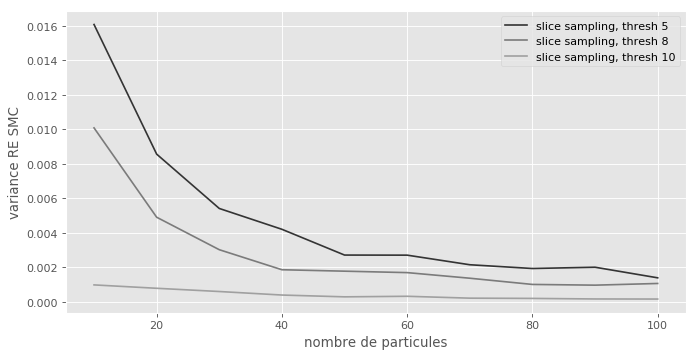

In [357]:
_= plt.style.use('ggplot')
_= plt.figure(figsize=(10,5), dpi= 80)
#ax= pd_results.plot(figsize=(10,5))

#ax= plt.figure(figsize=(10,5), dpi= 80)
#_= plt.plot(pd_results.var_rd_5, label= 'gaussian kernel, thresh 5', color='#003AD5')
#_= plt.plot(pd_results.var_rd_8, label= 'gaussian kernel, thresh 8', color='#0077D5')
#_= plt.plot(pd_results.var_rd_10, label= 'gaussian kernel, thresh 10', color='#00A5D5')
_= plt.plot(pd_results.var_ss_5, label= 'slice sampling, thresh 5', color='#343434')
_= plt.plot(pd_results.var_ss_8, label= 'slice sampling, thresh 8', color='#7B7B7B')
_= plt.plot(pd_results.var_ss_10, label= 'slice sampling, thresh 10', color='#A0A0A0')
ax= plt.gca()
_= ax.set_xlabel('nombre de particules')
_= ax.set_ylabel('variance RE SMC')
_= plt.legend()
plt.savefig(r'D:\3A\Hidden Markov Model\Projet\variance_nb_part_thresh_kernel')
plt.show()



In [325]:
import pandas as pd

pd_results= pd.DataFrame(results_list, columns= ['eps', 'nb_particules', 'fktype', 'distrib'])
pd_results= pd_results.append(pd.DataFrame(results_list1, columns= ['eps', 'nb_particules', 'fktype', 'distrib']))
pd_results= pd_results.reset_index(drop=True)

pd_results.loc[30:39, 'eps']=5#corrections
pd_results.loc[40:49, 'eps']=8
pd_results.loc[50:59, 'eps']=10

#pd_results['distrib']= pd_results['distrib'].apply(np.asarray)
#pd_results['log_distrib']=pd_results['distrib'].apply(np.log)
pd_results['log_distrib']=pd_results['distrib'].apply(log_distrib)

pd_results['var']= pd_results['distrib'].apply(np.var)
pd_results

,eps,nb_particules,fktype,distrib,log_distrib,var
0,5,10,ss,"[0.32659200000000005, 0.3732480000000001, 0.25...","[-1.1190435935406307, -0.9855122009161079, -1....",0.016075
1,5,20,ss,"[0.49419, 0.3392418531249999, 0.346275, 0.3891...","[-0.7048352203551363, -1.0810419949254422, -1....",0.008560
2,5,30,ss,"[0.5015249975206804, 0.5551684329333333, 0.370...","[-0.6901018273175465, -0.5884837285145186, -0....",0.005410
3,5,40,ss,"[0.3861769542434692, 0.237475274765625, 0.4284...","[-0.9514595838819855, -1.437691767176873, -0.8...",0.004202
4,5,50,ss,"[0.41590409527295996, 0.30724937907717514, 0.3...","[-0.8773005855085837, -1.1800955514422655, -1....",0.002709
5,5,60,ss,"[0.29316201058063274, 0.44193296483950617, 0.4...","[-1.227029885643214, -0.8165970716655098, -0.8...",0.002703
6,5,70,ss,"[0.34711710367337345, 0.48002454153592605, 0.4...","[-1.058093081403974, -0.7339180481873564, -0.8...",0.002147
7,5,80,ss,"[0.3855542008898212, 0.38771132065057756, 0.33...","[-0.9530734969258746, -0.947494235220131, -1.0...",0.001929
8,5,90,ss,"[0.3851157272353985, 0.3318411292283755, 0.357...","[-0.9542113996407281, -1.1030989510165106, -1....",0.002004
9,5,100,ss,"[0.42596713637708644, 0.36122962339900794, 0.3...","[-0.8533930803432952, -1.018241446962258, -1.0...",0.001389


In [328]:
distrib_eps5_50p_ss_theta3= pd_results.loc[4, 'distrib']
logdistrib_eps5_50p_ss_theta3= np.log(distrib_eps5_50p_ss_theta3)

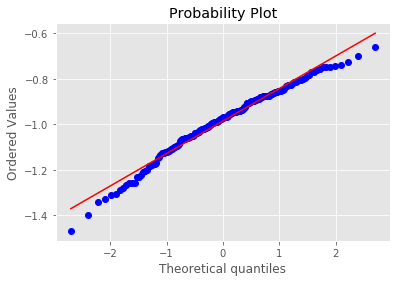

In [353]:
from scipy.stats import probplot

#_=probplot(pd_results.loc[5, 'distrib'],plot=plt)
_=probplot(np.log(pd_results.loc[4, 'distrib']),plot=plt)
plt.savefig(r'D:\3A\Hidden Markov Model\Projet\proba_plot.jpg')

plt.show()

### RMSE

In [393]:
results_fixed = []
results_adapt = []

for eps in [5,10,15,20,25,30]:
    adapt_fk = adapt_RE_FK(200, 0.5, eps_target=eps, theta= 8, data=Y)
    smc = RE_SMC(fk=adapt_fk, N=50)
    smc.run()
    list_eps_int = smc.fk.eps_list

    fk1= fixed_RE_FK(list_eps_int, Y)
    re_abc1 = RE_ABC(theta0=2, prior=unif10, q=norm_pdf, q_ker=norm_kernel, refk=fk1, N=50, print_step=True)
    re_abc1.run(200)
    
    fk2= adapt_RE_FK(200, 0.5, eps_target=eps, data=Y)
    re_abc2 = RE_ABC(theta0=2, prior=unif10, q=norm_pdf, q_ker=norm_kernel, refk=fk2, N=50, print_step=True)
    re_abc2.run(400)

    results_fixed.append(np.sqrt(np.mean((np.array(re_abc1.theta_list)-3)**2)))
    results_adapt.append(np.sqrt(np.mean((np.array(re_abc2.theta_list)-3)**2)))


--------------------------
step: 0, theta: 2, nb accepted: 0
--------------------------
step: 1, theta: 2, nb accepted: 1
proposal: 2.1084682267204586
previous: 2
-------
L_prime:    0.25
L_tp:       0.48
prob ratio: 0.5208333333333334
u:          0.7254064766923766
>> Rejected

--------------------------
step: 2, theta: 2, nb accepted: 1
proposal: 1.49872557218143

C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log



previous: 2
-------
L_prime:    0.0625
L_tp:       0.48
prob ratio: 0.13020833333333334
u:          0.17043609423737627
>> Rejected

--------------------------
step: 3, theta: 2, nb accepted: 1
proposal: 2.3947431091300713
previous: 2
-------
L_prime:    0.125
L_tp:       0.48
prob ratio: 0.2604166666666667
u:          0.2889257901699882
>> Rejected

--------------------------
step: 4, theta: 2, nb accepted: 1
proposal: 3.4555435634520824
previous: 2
-------
L_prime:    0.25
L_tp:       0.48
prob ratio: 0.5208333333333334
u:          0.9727684205422383
>> Rejected

--------------------------
step: 5, theta: 2, nb accepted: 1
proposal: 3.8594310581142386
previous: 2
-------
L_prime:    0.3
L_tp:       0.48
prob ratio: 0.625
u:          0.7253548490405922
>> Rejected

--------------------------
step: 6, theta: 2, nb accepted: 1
proposal: 1.5900787804849794
previous: 2
-------
L_prime:    0.125
L_tp:       0.48
prob ratio: 0.2604166666666667
u:          0.465018540086497
>> Rejected

---

-------
L_prime:    0.74
L_tp:       0.52
prob ratio: 1.423076923076923
u:          0.2006271815676426
>> Accepted

--------------------------
step: 42, theta: 5.230484480388117, nb accepted: 20
proposal: 4.57536808534903
previous: 5.230484480388117
-------
L_prime:    0.5
L_tp:       0.74
prob ratio: 0.6756756756756757
u:          0.6831862965077261
>> Rejected

--------------------------
step: 43, theta: 5.230484480388117, nb accepted: 20
proposal: 5.459856329658846
previous: 5.230484480388117
-------
L_prime:    0.68
L_tp:       0.74
prob ratio: 0.9189189189189192
u:          0.2907907165158038
>> Accepted

--------------------------
step: 44, theta: 5.459856329658846, nb accepted: 21
proposal: 3.3987413578362538
previous: 5.459856329658846
-------
L_prime:    0.175
L_tp:       0.68
prob ratio: 0.2573529411764706
u:          0.1606308621787481
>> Accepted

--------------------------
step: 45, theta: 3.3987413578362538, nb accepted: 22
proposal: 4.573347186862991
previous: 3.39874135

-------
L_prime:    0.21
L_tp:       0.66
prob ratio: 0.3181818181818181
u:          0.31424365305785795
>> Accepted

--------------------------
step: 78, theta: 3.6052297521402834, nb accepted: 53
proposal: 2.8804309603391944
previous: 3.6052297521402834
-------
L_prime:    0.085
L_tp:       0.21
prob ratio: 0.4047619047619048
u:          0.5675057531435406
>> Rejected

--------------------------
step: 79, theta: 3.6052297521402834, nb accepted: 53
proposal: 2.3909269736540124
previous: 3.6052297521402834
-------
L_prime:    0.015625
L_tp:       0.21
prob ratio: 0.0744047619047619
u:          0.11838525318285009
>> Rejected

--------------------------
step: 80, theta: 3.6052297521402834, nb accepted: 53
proposal: 3.008268255731641
previous: 3.6052297521402834
-------
L_prime:    0.085
L_tp:       0.21
prob ratio: 0.40476190476190477
u:          0.3684969500808468
>> Accepted

--------------------------
step: 81, theta: 3.008268255731641, nb accepted: 54
proposal: 3.3174579799804262
pr

C:\Users\Tristan Legris\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in double_scalars


proposal: 10.624364664917959
previous: 9.228269730638877
-------
L_prime:    1.0
L_tp:       0.98
prob ratio: 0.0
u:          0.3381776214740142
>> Rejected

--------------------------
step: 116, theta: 9.228269730638877, nb accepted: 82
proposal: 9.953395487234
previous: 9.228269730638877
-------
L_prime:    1.0
L_tp:       0.98
prob ratio: 1.0204081632653061
u:          0.8445381246263854
>> Accepted

--------------------------
step: 117, theta: 9.953395487234, nb accepted: 83
proposal: 10.93487360599615
previous: 9.953395487234
-------
L_prime:    0.98
L_tp:       1.0
prob ratio: 0.0
u:          0.569865607414443
>> Rejected

--------------------------
step: 118, theta: 9.953395487234, nb accepted: 83
proposal: 11.333297607863432
previous: 9.953395487234
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 0.0
u:          0.14382775290333438
>> Rejected

--------------------------
step: 119, theta: 9.953395487234, nb accepted: 83
proposal: 10.57950793526633
previous: 9.953395487234
-

-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.308010865943664
>> Accepted

--------------------------
step: 155, theta: 8.989290895331674, nb accepted: 107
proposal: 9.388070233107703
previous: 8.989290895331674
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.5078186852056027
>> Accepted

--------------------------
step: 156, theta: 9.388070233107703, nb accepted: 108
proposal: 9.919251780208842
previous: 9.388070233107703
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.43113446620404916
>> Accepted

--------------------------
step: 157, theta: 9.919251780208842, nb accepted: 109
proposal: 9.125174084835685
previous: 9.919251780208842
-------
L_prime:    0.98
L_tp:       1.0
prob ratio: 0.98
u:          0.5043466379385069
>> Accepted

--------------------------
step: 158, theta: 9.125174084835685, nb accepted: 110
proposal: 8.685943006534703
previous: 9.125174084835685
-------
L_prime:    1.0
L_tp:       0.98
prob rati

-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.5333598677929495
>> Accepted

--------------------------
step: 196, theta: 9.00747065032097, nb accepted: 139
proposal: 7.00949423516326
previous: 9.00747065032097
-------
L_prime:    0.96
L_tp:       1.0
prob ratio: 0.96
u:          0.9890553635632063
>> Rejected

--------------------------
step: 197, theta: 9.00747065032097, nb accepted: 139
proposal: 9.612939165687903
previous: 9.00747065032097
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.901152231942805
>> Accepted

--------------------------
step: 198, theta: 9.612939165687903, nb accepted: 140
proposal: 9.863992259440572
previous: 9.612939165687903
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.8090472956545471
>> Accepted

--------------------------
step: 199, theta: 9.863992259440572, nb accepted: 141
proposal: 9.42338726150629
previous: 9.863992259440572
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u

-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.2737512814472407
>> Accepted

--------------------------
step: 233, theta: 9.060611897886607, nb accepted: 168
proposal: 6.980421248824699
previous: 9.060611897886607
-------
L_prime:    0.96
L_tp:       1.0
prob ratio: 0.96
u:          0.17067539190687697
>> Accepted

--------------------------
step: 234, theta: 6.980421248824699, nb accepted: 169
proposal: 6.480535888352906
previous: 6.980421248824699
-------
L_prime:    0.84
L_tp:       0.96
prob ratio: 0.8749999999999998
u:          0.9359055482348388
>> Rejected

--------------------------
step: 235, theta: 6.980421248824699, nb accepted: 169
proposal: 8.243035231411035
previous: 6.980421248824699
-------
L_prime:    1.0
L_tp:       0.96
prob ratio: 1.0416666666666665
u:          0.6204033792117911
>> Accepted

--------------------------
step: 236, theta: 8.243035231411035, nb accepted: 170
proposal: 8.075715963469131
previous: 8.243035231411035
-------
L_prime:

-------
L_prime:    0.74
L_tp:       0.68
prob ratio: 1.088235294117647
u:          0.7629498346276237
>> Accepted

--------------------------
step: 271, theta: 5.603728107499439, nb accepted: 201
proposal: 4.878471996170948
previous: 5.603728107499439
-------
L_prime:    0.62
L_tp:       0.74
prob ratio: 0.8378378378378379
u:          0.508615844883264
>> Accepted

--------------------------
step: 272, theta: 4.878471996170948, nb accepted: 202
proposal: 5.792125855798619
previous: 4.878471996170948
-------
L_prime:    0.66
L_tp:       0.62
prob ratio: 1.0645161290322582
u:          0.37354298234111416
>> Accepted

--------------------------
step: 273, theta: 5.792125855798619, nb accepted: 203
proposal: 7.2657620468853175
previous: 5.792125855798619
-------
L_prime:    0.9
L_tp:       0.66
prob ratio: 1.363636363636364
u:          0.9834780752882156
>> Accepted

--------------------------
step: 274, theta: 7.2657620468853175, nb accepted: 204
proposal: 9.010789725713432
previous: 7.2

-------
L_prime:    0.1125
L_tp:       0.5
prob ratio: 0.225
u:          0.14932509022436335
>> Accepted

--------------------------
step: 307, theta: 3.1664434930669696, nb accepted: 237
proposal: 4.085410120642665
previous: 3.1664434930669696
-------
L_prime:    0.3
L_tp:       0.1125
prob ratio: 2.6666666666666665
u:          0.36808926731972713
>> Accepted

--------------------------
step: 308, theta: 4.085410120642665, nb accepted: 238
proposal: 4.420900008659996
previous: 4.085410120642665
-------
L_prime:    0.37
L_tp:       0.3
prob ratio: 1.2333333333333334
u:          0.851183107629816
>> Accepted

--------------------------
step: 309, theta: 4.420900008659996, nb accepted: 239
proposal: 6.234664714250343
previous: 4.420900008659996
-------
L_prime:    0.86
L_tp:       0.37
prob ratio: 2.3243243243243246
u:          0.6990389654330347
>> Accepted

--------------------------
step: 310, theta: 6.234664714250343, nb accepted: 240
proposal: 6.437922329240455
previous: 6.234664714

-------
L_prime:    0.92
L_tp:       0.94
prob ratio: 0.9787234042553192
u:          0.6252560932274626
>> Accepted

--------------------------
step: 348, theta: 8.09032733856271, nb accepted: 273
proposal: 8.354143297493176
previous: 8.09032733856271
-------
L_prime:    1.0
L_tp:       0.92
prob ratio: 1.0869565217391304
u:          0.8838640787541001
>> Accepted

--------------------------
step: 349, theta: 8.354143297493176, nb accepted: 274
proposal: 8.813025778376666
previous: 8.354143297493176
-------
L_prime:    0.96
L_tp:       1.0
prob ratio: 0.96
u:          0.014436442458424015
>> Accepted

--------------------------
step: 350, theta: 8.813025778376666, nb accepted: 275
proposal: 8.921452356398458
previous: 8.813025778376666
-------
L_prime:    0.98
L_tp:       0.96
prob ratio: 1.0208333333333333
u:          0.958605187831661
>> Accepted

--------------------------
step: 351, theta: 8.921452356398458, nb accepted: 276
proposal: 10.36087657825622
previous: 8.921452356398458
-

-------
L_prime:    0.98
L_tp:       0.86
prob ratio: 1.1395348837209303
u:          0.06968321608079386
>> Accepted

--------------------------
step: 388, theta: 7.650002053504549, nb accepted: 309
proposal: 7.119824165159584
previous: 7.650002053504549
-------
L_prime:    0.96
L_tp:       0.98
prob ratio: 0.9795918367346936
u:          0.2251898856655986
>> Accepted

--------------------------
step: 389, theta: 7.119824165159584, nb accepted: 310
proposal: 6.491178213740667
previous: 7.119824165159584
-------
L_prime:    0.82
L_tp:       0.96
prob ratio: 0.8541666666666666
u:          0.5666729978588381
>> Accepted

--------------------------
step: 390, theta: 6.491178213740667, nb accepted: 311
proposal: 5.867058166104268
previous: 6.491178213740667
-------
L_prime:    0.88
L_tp:       0.82
prob ratio: 1.0731707317073171
u:          0.29882999059438664
>> Accepted

--------------------------
step: 391, theta: 5.867058166104268, nb accepted: 312
proposal: 4.39756365726122
previous: 5

-------
L_prime:    0.08
L_tp:       0.13
prob ratio: 0.6153846153846153
u:          0.6431639160952869
>> Rejected

--------------------------
step: 23, theta: 3.5336471730854058, nb accepted: 11
proposal: 1.177699173841833
previous: 3.5336471730854058
-------
L_prime:    0.0625
L_tp:       0.13
prob ratio: 0.48076923076923084
u:          0.5932845814973707
>> Rejected

--------------------------
step: 24, theta: 3.5336471730854058, nb accepted: 11
proposal: 2.4054837780783136
previous: 3.5336471730854058
-------
L_prime:    0.03125
L_tp:       0.13
prob ratio: 0.24038461538461536
u:          0.4263120727582487
>> Rejected

--------------------------
step: 25, theta: 3.5336471730854058, nb accepted: 11
proposal: 2.089332705596756
previous: 3.5336471730854058
-------
L_prime:    0.0625
L_tp:       0.13
prob ratio: 0.4807692307692308
u:          0.5570186105037876
>> Rejected

--------------------------
step: 26, theta: 3.5336471730854058, nb accepted: 11
proposal: 4.475456832537541
pre

-------
L_prime:    0.58
L_tp:       0.72
prob ratio: 0.8055555555555557
u:          0.08480345916106302
>> Accepted

--------------------------
step: 61, theta: 4.498668176304918, nb accepted: 38
proposal: 4.31505400280018
previous: 4.498668176304918
-------
L_prime:    0.35
L_tp:       0.58
prob ratio: 0.603448275862069
u:          0.2809840595236228
>> Accepted

--------------------------
step: 62, theta: 4.31505400280018, nb accepted: 39
proposal: 5.765872715770342
previous: 4.31505400280018
-------
L_prime:    0.8
L_tp:       0.35
prob ratio: 2.285714285714286
u:          0.9218081183900388
>> Accepted

--------------------------
step: 63, theta: 5.765872715770342, nb accepted: 40
proposal: 3.8309522395360673
previous: 5.765872715770342
-------
L_prime:    0.25
L_tp:       0.8
prob ratio: 0.31249999999999994
u:          0.5719930041731881
>> Rejected

--------------------------
step: 64, theta: 5.765872715770342, nb accepted: 40
proposal: 4.764042190374905
previous: 5.765872715770

-------
L_prime:    0.47
L_tp:       0.8
prob ratio: 0.5874999999999998
u:          0.270139429778263
>> Accepted

--------------------------
step: 99, theta: 4.585211046435069, nb accepted: 66
proposal: 4.937323728431852
previous: 4.585211046435069
-------
L_prime:    0.58
L_tp:       0.47
prob ratio: 1.2340425531914894
u:          0.16026348127289725
>> Accepted

--------------------------
step: 100, theta: 4.937323728431852, nb accepted: 67
proposal: 4.863704499190855
previous: 4.937323728431852
-------
L_prime:    0.52
L_tp:       0.58
prob ratio: 0.8965517241379312
u:          0.8284330478529873
>> Accepted

--------------------------
step: 101, theta: 4.863704499190855, nb accepted: 68
proposal: 3.552002652762213
previous: 4.863704499190855
-------
L_prime:    0.25
L_tp:       0.52
prob ratio: 0.48076923076923067
u:          0.9019495554870968
>> Rejected

--------------------------
step: 102, theta: 4.863704499190855, nb accepted: 68
proposal: 5.291903753124673
previous: 4.86370

-------
L_prime:    0.82
L_tp:       0.92
prob ratio: 0.8913043478260867
u:          0.7098151738650196
>> Accepted

--------------------------
step: 138, theta: 6.2753249250058225, nb accepted: 96
proposal: 6.04315224541729
previous: 6.2753249250058225
-------
L_prime:    0.84
L_tp:       0.82
prob ratio: 1.024390243902439
u:          0.211507062292567
>> Accepted

--------------------------
step: 139, theta: 6.04315224541729, nb accepted: 97
proposal: 6.914958803357626
previous: 6.04315224541729
-------
L_prime:    0.92
L_tp:       0.84
prob ratio: 1.0952380952380953
u:          0.00011214653273372566
>> Accepted

--------------------------
step: 140, theta: 6.914958803357626, nb accepted: 98
proposal: 7.316917347278411
previous: 6.914958803357626
-------
L_prime:    0.9
L_tp:       0.92
prob ratio: 0.9782608695652172
u:          0.7204151053303377
>> Accepted

--------------------------
step: 141, theta: 7.316917347278411, nb accepted: 99
proposal: 6.728502978859675
previous: 7.3169

-------
L_prime:    1.0
L_tp:       0.92
prob ratio: 1.0869565217391302
u:          0.5684001835721674
>> Accepted

--------------------------
step: 175, theta: 7.436044434993736, nb accepted: 130
proposal: 7.404009255724495
previous: 7.436044434993736
-------
L_prime:    0.86
L_tp:       1.0
prob ratio: 0.8599999999999999
u:          0.5364726938467432
>> Accepted

--------------------------
step: 176, theta: 7.404009255724495, nb accepted: 131
proposal: 6.730225248737355
previous: 7.404009255724495
-------
L_prime:    0.92
L_tp:       0.86
prob ratio: 1.069767441860465
u:          0.5171573900539834
>> Accepted

--------------------------
step: 177, theta: 6.730225248737355, nb accepted: 132
proposal: 8.356669695935645
previous: 6.730225248737355
-------
L_prime:    1.0
L_tp:       0.92
prob ratio: 1.0869565217391304
u:          0.28040294747353267
>> Accepted

--------------------------
step: 178, theta: 8.356669695935645, nb accepted: 133
proposal: 9.698053962161598
previous: 8.356

-------
L_prime:    0.96
L_tp:       0.96
prob ratio: 1.0
u:          0.5468279285720122
>> Accepted

--------------------------
step: 214, theta: 9.006103006402716, nb accepted: 166
proposal: 10.579256463372607
previous: 9.006103006402716
-------
L_prime:    1.0
L_tp:       0.96
prob ratio: 0.0
u:          0.5189309539122805
>> Rejected

--------------------------
step: 215, theta: 9.006103006402716, nb accepted: 166
proposal: 10.737429260401328
previous: 9.006103006402716
-------
L_prime:    1.0
L_tp:       0.96
prob ratio: 0.0
u:          0.95532119689154
>> Rejected

--------------------------
step: 216, theta: 9.006103006402716, nb accepted: 166
proposal: 9.790286299839938
previous: 9.006103006402716
-------
L_prime:    1.0
L_tp:       0.96
prob ratio: 1.0416666666666667
u:          0.8002717746404485
>> Accepted

--------------------------
step: 217, theta: 9.790286299839938, nb accepted: 167
proposal: 8.598839935397692
previous: 9.790286299839938
-------
L_prime:    1.0
L_tp:   

-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.31823970924367684
>> Accepted

--------------------------
step: 247, theta: 9.190554658395257, nb accepted: 193
proposal: 10.671663961205637
previous: 9.190554658395257
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 0.0
u:          0.8618236107710557
>> Rejected

--------------------------
step: 248, theta: 9.190554658395257, nb accepted: 193
proposal: 8.067455286650487
previous: 9.190554658395257
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.9976635479377737
>> Accepted

--------------------------
step: 249, theta: 8.067455286650487, nb accepted: 194
proposal: 10.01086083851224
previous: 8.067455286650487
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 0.0
u:          0.33170316537695443
>> Rejected

--------------------------
step: 250, theta: 8.067455286650487, nb accepted: 194
proposal: 9.041837433881275
previous: 8.067455286650487
-------
L_prime:    0.98
L_tp:       1.0
prob rat

-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 0.0
u:          0.8585327667541826
>> Rejected

--------------------------
step: 281, theta: 9.327728133099654, nb accepted: 222
proposal: 8.854014715338902
previous: 9.327728133099654
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.28530207491488335
>> Accepted

--------------------------
step: 282, theta: 8.854014715338902, nb accepted: 223
proposal: 9.534643365880177
previous: 8.854014715338902
-------
L_prime:    0.98
L_tp:       1.0
prob ratio: 0.98
u:          0.530997047477125
>> Accepted

--------------------------
step: 283, theta: 9.534643365880177, nb accepted: 224
proposal: 9.185470326792778
previous: 9.534643365880177
-------
L_prime:    0.98
L_tp:       0.98
prob ratio: 1.0
u:          0.8245962156262064
>> Accepted

--------------------------
step: 284, theta: 9.185470326792778, nb accepted: 225
proposal: 8.21128224771102
previous: 9.185470326792778
-------
L_prime:    0.94
L_tp:       0.98
prob ra

-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 0.0
u:          0.416183168923685
>> Rejected

--------------------------
step: 320, theta: 9.848695838841634, nb accepted: 254
proposal: 9.156834334546522
previous: 9.848695838841634
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.08158762367077899
>> Accepted

--------------------------
step: 321, theta: 9.156834334546522, nb accepted: 255
proposal: 9.392898771197519
previous: 9.156834334546522
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.9757821390053868
>> Accepted

--------------------------
step: 322, theta: 9.392898771197519, nb accepted: 256
proposal: 8.982384398553842
previous: 9.392898771197519
-------
L_prime:    0.98
L_tp:       1.0
prob ratio: 0.9800000000000001
u:          0.8964926373310826
>> Accepted

--------------------------
step: 323, theta: 8.982384398553842, nb accepted: 257
proposal: 8.511367862804534
previous: 8.982384398553842
-------
L_prime:    0.98
L_tp:      

-------
L_prime:    0.74
L_tp:       0.94
prob ratio: 0.7872340425531915
u:          0.31734247329790566
>> Accepted

--------------------------
step: 361, theta: 5.743747892933678, nb accepted: 291
proposal: 6.473675356814306
previous: 5.743747892933678
-------
L_prime:    0.9
L_tp:       0.74
prob ratio: 1.2162162162162165
u:          0.5423852728553634
>> Accepted

--------------------------
step: 362, theta: 6.473675356814306, nb accepted: 292
proposal: 7.4818024690944425
previous: 6.473675356814306
-------
L_prime:    0.98
L_tp:       0.9
prob ratio: 1.0888888888888888
u:          0.689217923170516
>> Accepted

--------------------------
step: 363, theta: 7.4818024690944425, nb accepted: 293
proposal: 5.614104202383489
previous: 7.4818024690944425
-------
L_prime:    0.72
L_tp:       0.98
prob ratio: 0.7346938775510203
u:          0.2697625907011858
>> Accepted

--------------------------
step: 364, theta: 5.614104202383489, nb accepted: 294
proposal: 5.441651350214349
previous: 5

-------
L_prime:    1.0
L_tp:       0.84
prob ratio: 1.1904761904761907
u:          0.4730547921897251
>> Accepted

--------------------------
step: 397, theta: 9.152038626938076, nb accepted: 325
proposal: 9.592933077054875
previous: 9.152038626938076
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.1386963187492879
>> Accepted

--------------------------
step: 398, theta: 9.592933077054875, nb accepted: 326
proposal: 9.751730811090106
previous: 9.592933077054875
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.7151413065493237
>> Accepted

--------------------------
step: 399, theta: 9.751730811090106, nb accepted: 327
proposal: 10.083302545243798
previous: 9.751730811090106
-------
L_prime:    0.96
L_tp:       1.0
prob ratio: 0.0
u:          0.6009390776944888
>> Rejected

--------------------------
step: 0, theta: 2, nb accepted: 0
--------------------------
step: 1, theta: 2, nb accepted: 1
proposal: 1.7384271823698714
previous: 2
-------


-------
L_prime:    0.98
L_tp:       0.98
prob ratio: 1.0
u:          0.596492527500911
>> Accepted

--------------------------
step: 38, theta: 9.387435789855427, nb accepted: 28
proposal: 9.29659506052948
previous: 9.387435789855427
-------
L_prime:    1.0
L_tp:       0.98
prob ratio: 1.0204081632653061
u:          0.9845788801689765
>> Accepted

--------------------------
step: 39, theta: 9.29659506052948, nb accepted: 29
proposal: 9.147258089781252
previous: 9.29659506052948
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.8432976583808548
>> Accepted

--------------------------
step: 40, theta: 9.147258089781252, nb accepted: 30
proposal: 8.399714731802764
previous: 9.147258089781252
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.18288385764454107
>> Accepted

--------------------------
step: 41, theta: 8.399714731802764, nb accepted: 31
proposal: 9.142050222646336
previous: 8.399714731802764
-------
L_prime:    1.0
L_tp:       1.0
prob 

-------
L_prime:    0.98
L_tp:       1.0
prob ratio: 0.9799999999999999
u:          0.9492743838044461
>> Accepted

--------------------------
step: 82, theta: 8.886341541583363, nb accepted: 62
proposal: 8.114704309669884
previous: 8.886341541583363
-------
L_prime:    0.94
L_tp:       0.98
prob ratio: 0.9591836734693876
u:          0.9952041537428293
>> Rejected

--------------------------
step: 83, theta: 8.886341541583363, nb accepted: 62
proposal: 9.337324129376052
previous: 8.886341541583363
-------
L_prime:    0.98
L_tp:       0.98
prob ratio: 1.0
u:          0.35269618086491306
>> Accepted

--------------------------
step: 84, theta: 9.337324129376052, nb accepted: 63
proposal: 9.97941273805484
previous: 9.337324129376052
-------
L_prime:    1.0
L_tp:       0.98
prob ratio: 1.0204081632653061
u:          0.501733529550992
>> Accepted

--------------------------
step: 85, theta: 9.97941273805484, nb accepted: 64
proposal: 9.420024780677561
previous: 9.97941273805484
-------
L_pr

-------
L_prime:    1.0
L_tp:       0.94
prob ratio: 1.0638297872340425
u:          0.8013791690920767
>> Accepted

--------------------------
step: 119, theta: 9.42648697924136, nb accepted: 96
proposal: 8.792636914683918
previous: 9.42648697924136
-------
L_prime:    0.96
L_tp:       1.0
prob ratio: 0.96
u:          0.9505784930304235
>> Accepted

--------------------------
step: 120, theta: 8.792636914683918, nb accepted: 97
proposal: 8.611910670081722
previous: 8.792636914683918
-------
L_prime:    0.94
L_tp:       0.96
prob ratio: 0.9791666666666666
u:          0.19938465863069632
>> Accepted

--------------------------
step: 121, theta: 8.611910670081722, nb accepted: 98
proposal: 9.40651861629057
previous: 8.611910670081722
-------
L_prime:    0.96
L_tp:       0.94
prob ratio: 1.0212765957446808
u:          0.37205385110833855
>> Accepted

--------------------------
step: 122, theta: 9.40651861629057, nb accepted: 99
proposal: 9.000841515234814
previous: 9.40651861629057
-------

proposal: 5.960440648180649
previous: 6.204414835952897
-------
L_prime:    0.8
L_tp:       0.92
prob ratio: 0.8695652173913044
u:          0.4294663189790079
>> Accepted

--------------------------
step: 163, theta: 5.960440648180649, nb accepted: 133
proposal: 4.64240263689593
previous: 5.960440648180649
-------
L_prime:    0.5
L_tp:       0.8
prob ratio: 0.6249999999999999
u:          0.42902479029086493
>> Accepted

--------------------------
step: 164, theta: 4.64240263689593, nb accepted: 134
proposal: 3.9693980514256997
previous: 4.64240263689593
-------
L_prime:    0.49
L_tp:       0.5
prob ratio: 0.98
u:          0.9427116578364718
>> Accepted

--------------------------
step: 165, theta: 3.9693980514256997, nb accepted: 135
proposal: 4.202129139909253
previous: 3.9693980514256997
-------
L_prime:    0.42
L_tp:       0.49
prob ratio: 0.8571428571428572
u:          0.89210682284491
>> Rejected

--------------------------
step: 166, theta: 3.9693980514256997, nb accepted: 135
pr

-------
L_prime:    0.72
L_tp:       0.84
prob ratio: 0.8571428571428571
u:          0.9629677594583869
>> Rejected

--------------------------
step: 204, theta: 6.577851986721593, nb accepted: 163
proposal: 7.559852028318693
previous: 6.577851986721593
-------
L_prime:    0.9
L_tp:       0.84
prob ratio: 1.0714285714285714
u:          0.9926888180430744
>> Accepted

--------------------------
step: 205, theta: 7.559852028318693, nb accepted: 164
proposal: 8.453045624019673
previous: 7.559852028318693
-------
L_prime:    1.0
L_tp:       0.9
prob ratio: 1.1111111111111112
u:          0.0224169819938691
>> Accepted

--------------------------
step: 206, theta: 8.453045624019673, nb accepted: 165
proposal: 8.128530697713707
previous: 8.453045624019673
-------
L_prime:    0.98
L_tp:       1.0
prob ratio: 0.98
u:          0.39918278895153536
>> Accepted

--------------------------
step: 207, theta: 8.128530697713707, nb accepted: 166
proposal: 9.682943789573542
previous: 8.128530697713707
-

-------
L_prime:    1.0
L_tp:       0.96
prob ratio: 1.0416666666666667
u:          0.9459655164537331
>> Accepted

--------------------------
step: 242, theta: 7.823630085259848, nb accepted: 197
proposal: 8.188505520264025
previous: 7.823630085259848
-------
L_prime:    0.94
L_tp:       1.0
prob ratio: 0.9399999999999998
u:          0.5623576894924267
>> Accepted

--------------------------
step: 243, theta: 8.188505520264025, nb accepted: 198
proposal: 9.459837121790882
previous: 8.188505520264025
-------
L_prime:    1.0
L_tp:       0.94
prob ratio: 1.0638297872340425
u:          0.5529057560860076
>> Accepted

--------------------------
step: 244, theta: 9.459837121790882, nb accepted: 199
proposal: 9.138596775779416
previous: 9.459837121790882
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.13071736750590068
>> Accepted

--------------------------
step: 245, theta: 9.138596775779416, nb accepted: 200
proposal: 8.515832625338868
previous: 9.138596775779416
---

-------
L_prime:    0.98
L_tp:       0.96
prob ratio: 1.0208333333333335
u:          0.3250934269722858
>> Accepted

--------------------------
step: 277, theta: 8.592814181850407, nb accepted: 228
proposal: 10.560086029844449
previous: 8.592814181850407
-------
L_prime:    1.0
L_tp:       0.98
prob ratio: 0.0
u:          0.9225348674248246
>> Rejected

--------------------------
step: 278, theta: 8.592814181850407, nb accepted: 228
proposal: 8.911612765646744
previous: 8.592814181850407
-------
L_prime:    0.96
L_tp:       0.98
prob ratio: 0.979591836734694
u:          0.6645632157663758
>> Accepted

--------------------------
step: 279, theta: 8.911612765646744, nb accepted: 229
proposal: 9.10850670996126
previous: 8.911612765646744
-------
L_prime:    0.98
L_tp:       0.96
prob ratio: 1.0208333333333335
u:          0.07945979523229163
>> Accepted

--------------------------
step: 280, theta: 9.10850670996126, nb accepted: 230
proposal: 10.600814390643269
previous: 9.10850670996126
-

-------
L_prime:    0.86
L_tp:       0.9
prob ratio: 0.9555555555555556
u:          0.6454349060493989
>> Accepted

--------------------------
step: 315, theta: 6.579282866822466, nb accepted: 261
proposal: 8.697807894872183
previous: 6.579282866822466
-------
L_prime:    1.0
L_tp:       0.86
prob ratio: 1.1627906976744184
u:          0.08009126916827358
>> Accepted

--------------------------
step: 316, theta: 8.697807894872183, nb accepted: 262
proposal: 7.670896312920022
previous: 8.697807894872183
-------
L_prime:    0.98
L_tp:       1.0
prob ratio: 0.98
u:          0.9391065196844292
>> Accepted

--------------------------
step: 317, theta: 7.670896312920022, nb accepted: 263
proposal: 8.786325428060962
previous: 7.670896312920022
-------
L_prime:    0.98
L_tp:       0.98
prob ratio: 1.0
u:          0.9634779736152266
>> Accepted

--------------------------
step: 318, theta: 8.786325428060962, nb accepted: 264
proposal: 8.813783766030637
previous: 8.786325428060962
-------
L_prime

-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.09815303391102193
>> Accepted

--------------------------
step: 353, theta: 9.443909276501739, nb accepted: 295
proposal: 10.314006109196097
previous: 9.443909276501739
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 0.0
u:          0.09271926686509213
>> Rejected

--------------------------
step: 354, theta: 9.443909276501739, nb accepted: 295
proposal: 10.93006493494611
previous: 9.443909276501739
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 0.0
u:          0.1677004921780716
>> Rejected

--------------------------
step: 355, theta: 9.443909276501739, nb accepted: 295
proposal: 8.336384059668447
previous: 9.443909276501739
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.03389735397588922
>> Accepted

--------------------------
step: 356, theta: 8.336384059668447, nb accepted: 296
proposal: 8.007248890851645
previous: 8.336384059668447
-------
L_prime:    1.0
L_tp:       1.0
prob rat

-------
L_prime:    0.88
L_tp:       0.94
prob ratio: 0.9361702127659575
u:          0.9185920280367504
>> Accepted

--------------------------
step: 394, theta: 7.05425501501031, nb accepted: 331
proposal: 7.004862840975341
previous: 7.05425501501031
-------
L_prime:    0.92
L_tp:       0.88
prob ratio: 1.0454545454545454
u:          0.12500901321915292
>> Accepted

--------------------------
step: 395, theta: 7.004862840975341, nb accepted: 332
proposal: 8.852136100386263
previous: 7.004862840975341
-------
L_prime:    0.98
L_tp:       0.92
prob ratio: 1.0652173913043477
u:          0.28505198409310173
>> Accepted

--------------------------
step: 396, theta: 8.852136100386263, nb accepted: 333
proposal: 9.262140713954905
previous: 8.852136100386263
-------
L_prime:    0.98
L_tp:       0.98
prob ratio: 1.0
u:          0.03569263079809526
>> Accepted

--------------------------
step: 397, theta: 9.262140713954905, nb accepted: 334
proposal: 8.487303451565374
previous: 9.26214071395490

-------
L_prime:    0.125
L_tp:       1.0
prob ratio: 0.125
u:          0.13917000533367085
>> Rejected

--------------------------
step: 36, theta: 2, nb accepted: 1
proposal: 1.1363175532598297
previous: 2
-------
L_prime:    0.5
L_tp:       1.0
prob ratio: 0.5
u:          0.576604611758617
>> Rejected

--------------------------
step: 37, theta: 2, nb accepted: 1
proposal: 1.0754967155007384
previous: 2
-------
L_prime:    0.5
L_tp:       1.0
prob ratio: 0.5
u:          0.5209856876133703
>> Rejected

--------------------------
step: 38, theta: 2, nb accepted: 1
proposal: -0.317686255371485
previous: 2
-------
L_prime:    0.5
L_tp:       1.0
prob ratio: 0.0
u:          0.236226141899189
>> Rejected

--------------------------
step: 39, theta: 2, nb accepted: 1
proposal: 2.713971938519078
previous: 2
-------
L_prime:    0.5
L_tp:       1.0
prob ratio: 0.5
u:          0.792439782005246
>> Rejected

--------------------------
step: 40, theta: 2, nb accepted: 1
proposal: 2.8249637822519

-------
L_prime:    0.76
L_tp:       0.62
prob ratio: 1.2258064516129035
u:          0.7965324957507095
>> Accepted

--------------------------
step: 75, theta: 5.395704917916437, nb accepted: 16
proposal: 5.857660811389421
previous: 5.395704917916437
-------
L_prime:    0.84
L_tp:       0.76
prob ratio: 1.1052631578947367
u:          0.4322234592602586
>> Accepted

--------------------------
step: 76, theta: 5.857660811389421, nb accepted: 17
proposal: 6.010010130158722
previous: 5.857660811389421
-------
L_prime:    0.84
L_tp:       0.84
prob ratio: 1.0
u:          0.12699206516594164
>> Accepted

--------------------------
step: 77, theta: 6.010010130158722, nb accepted: 18
proposal: 6.910474347697354
previous: 6.010010130158722
-------
L_prime:    0.88
L_tp:       0.84
prob ratio: 1.0476190476190477
u:          0.5837282337656577
>> Accepted

--------------------------
step: 78, theta: 6.910474347697354, nb accepted: 19
proposal: 7.015236905048331
previous: 6.910474347697354
------

-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 0.0
u:          0.7883815415170735
>> Rejected

--------------------------
step: 109, theta: 9.720338044507407, nb accepted: 46
proposal: 9.58617754371582
previous: 9.720338044507407
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.11684928981488307
>> Accepted

--------------------------
step: 110, theta: 9.58617754371582, nb accepted: 47
proposal: 8.048917002131866
previous: 9.58617754371582
-------
L_prime:    0.96
L_tp:       1.0
prob ratio: 0.96
u:          0.7726116504955693
>> Accepted

--------------------------
step: 111, theta: 8.048917002131866, nb accepted: 48
proposal: 7.649887776352468
previous: 8.048917002131866
-------
L_prime:    0.92
L_tp:       0.96
prob ratio: 0.9583333333333335
u:          0.3991753869814436
>> Accepted

--------------------------
step: 112, theta: 7.649887776352468, nb accepted: 49
proposal: 9.80865065674714
previous: 7.649887776352468
-------
L_prime:    1.0
L_tp:       0.92

-------
L_prime:    0.96
L_tp:       1.0
prob ratio: 0.96
u:          0.44267141552309797
>> Accepted

--------------------------
step: 143, theta: 8.450724614877277, nb accepted: 72
proposal: 9.159013988208814
previous: 8.450724614877277
-------
L_prime:    0.98
L_tp:       0.96
prob ratio: 1.0208333333333333
u:          0.43148403201179086
>> Accepted

--------------------------
step: 144, theta: 9.159013988208814, nb accepted: 73
proposal: 9.082149113496108
previous: 9.159013988208814
-------
L_prime:    1.0
L_tp:       0.98
prob ratio: 1.0204081632653061
u:          0.014677591386855204
>> Accepted

--------------------------
step: 145, theta: 9.082149113496108, nb accepted: 74
proposal: 7.8998742611930535
previous: 9.082149113496108
-------
L_prime:    0.94
L_tp:       1.0
prob ratio: 0.94
u:          0.7198808546958525
>> Accepted

--------------------------
step: 146, theta: 7.8998742611930535, nb accepted: 75
proposal: 8.225095425613612
previous: 7.8998742611930535
-------
L_pr

-------
L_prime:    0.31
L_tp:       0.28
prob ratio: 1.107142857142857
u:          0.039824035700429694
>> Accepted

--------------------------
step: 176, theta: 4.046621379990028, nb accepted: 95
proposal: 2.9150059327706064
previous: 4.046621379990028
-------
L_prime:    0.0775
L_tp:       0.31
prob ratio: 0.25000000000000006
u:          0.17307421217277263
>> Accepted

--------------------------
step: 177, theta: 2.9150059327706064, nb accepted: 96
proposal: 1.9216045051346544
previous: 2.9150059327706064
-------
L_prime:    0.03125
L_tp:       0.0775
prob ratio: 0.40322580645161293
u:          0.46696360793920977
>> Rejected

--------------------------
step: 178, theta: 2.9150059327706064, nb accepted: 96
proposal: 2.7956499901429224
previous: 2.9150059327706064
-------
L_prime:    0.05125
L_tp:       0.0775
prob ratio: 0.6612903225806452
u:          0.381185301650243
>> Accepted

--------------------------
step: 179, theta: 2.7956499901429224, nb accepted: 97
proposal: 1.64008100

-------
L_prime:    0.98
L_tp:       0.96
prob ratio: 1.0208333333333333
u:          0.18278977114726558
>> Accepted

--------------------------
step: 217, theta: 9.860475220604865, nb accepted: 124
proposal: 10.910084267476217
previous: 9.860475220604865
-------
L_prime:    1.0
L_tp:       0.98
prob ratio: 0.0
u:          0.32489592025894076
>> Rejected

--------------------------
step: 218, theta: 9.860475220604865, nb accepted: 124
proposal: 9.42199653150418
previous: 9.860475220604865
-------
L_prime:    1.0
L_tp:       0.98
prob ratio: 1.0204081632653061
u:          0.3951358265882292
>> Accepted

--------------------------
step: 219, theta: 9.42199653150418, nb accepted: 125
proposal: 6.754727034002418
previous: 9.42199653150418
-------
L_prime:    0.82
L_tp:       1.0
prob ratio: 0.82
u:          0.763619790425515
>> Accepted

--------------------------
step: 220, theta: 6.754727034002418, nb accepted: 126
proposal: 6.392327699474074
previous: 6.754727034002418
-------
L_prime: 

-------
L_prime:    0.38
L_tp:       0.8
prob ratio: 0.47499999999999987
u:          0.052347330220573585
>> Accepted

--------------------------
step: 250, theta: 4.939956085437217, nb accepted: 153
proposal: 5.45749022980901
previous: 4.939956085437217
-------
L_prime:    0.78
L_tp:       0.38
prob ratio: 2.052631578947368
u:          0.5275403705609271
>> Accepted

--------------------------
step: 251, theta: 5.45749022980901, nb accepted: 154
proposal: 4.272171331119454
previous: 5.45749022980901
-------
L_prime:    0.34
L_tp:       0.78
prob ratio: 0.43589743589743585
u:          0.6134426707723324
>> Rejected

--------------------------
step: 252, theta: 5.45749022980901, nb accepted: 154
proposal: 4.280405985528989
previous: 5.45749022980901
-------
L_prime:    0.5
L_tp:       0.78
prob ratio: 0.641025641025641
u:          0.7815412905663305
>> Rejected

--------------------------
step: 253, theta: 5.45749022980901, nb accepted: 154
proposal: 3.2710222176349104
previous: 5.45749

-------
L_prime:    0.86
L_tp:       0.9
prob ratio: 0.9555555555555554
u:          0.8332852507427447
>> Accepted

--------------------------
step: 289, theta: 6.242643890688268, nb accepted: 184
proposal: 5.603329214780394
previous: 6.242643890688268
-------
L_prime:    0.76
L_tp:       0.86
prob ratio: 0.8837209302325583
u:          0.07237409996728872
>> Accepted

--------------------------
step: 290, theta: 5.603329214780394, nb accepted: 185
proposal: 4.991735339744624
previous: 5.603329214780394
-------
L_prime:    0.66
L_tp:       0.76
prob ratio: 0.868421052631579
u:          0.66739648453453
>> Accepted

--------------------------
step: 291, theta: 4.991735339744624, nb accepted: 186
proposal: 3.4201814042113106
previous: 4.991735339744624
-------
L_prime:    0.25
L_tp:       0.66
prob ratio: 0.3787878787878788
u:          0.46108427185275147
>> Rejected

--------------------------
step: 292, theta: 4.991735339744624, nb accepted: 186
proposal: 5.996362359167711
previous: 4.9

-------
L_prime:    1.0
L_tp:       0.98
prob ratio: 1.0204081632653061
u:          0.3244290623370707
>> Accepted

--------------------------
step: 331, theta: 9.192200906653847, nb accepted: 219
proposal: 8.285450740684656
previous: 9.192200906653847
-------
L_prime:    0.92
L_tp:       1.0
prob ratio: 0.92
u:          0.28214421913998233
>> Accepted

--------------------------
step: 332, theta: 8.285450740684656, nb accepted: 220
proposal: 9.313886645748237
previous: 8.285450740684656
-------
L_prime:    1.0
L_tp:       0.92
prob ratio: 1.0869565217391304
u:          0.8307572423728932
>> Accepted

--------------------------
step: 333, theta: 9.313886645748237, nb accepted: 221
proposal: 9.879643523528
previous: 9.313886645748237
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.2855143526159645
>> Accepted

--------------------------
step: 334, theta: 9.879643523528, nb accepted: 222
proposal: 10.205295841452681
previous: 9.879643523528
-------
L_prime:    1.0
L

-------
L_prime:    0.39
L_tp:       0.58
prob ratio: 0.6724137931034484
u:          0.16663209864803852
>> Accepted

--------------------------
step: 370, theta: 4.180258838077753, nb accepted: 245
proposal: 3.998597511147463
previous: 4.180258838077753
-------
L_prime:    0.41
L_tp:       0.39
prob ratio: 1.0512820512820509
u:          0.27516204434151637
>> Accepted

--------------------------
step: 371, theta: 3.998597511147463, nb accepted: 246
proposal: 4.7215802015103785
previous: 3.998597511147463
-------
L_prime:    0.54
L_tp:       0.41
prob ratio: 1.3170731707317074
u:          0.20742686279393574
>> Accepted

--------------------------
step: 372, theta: 4.7215802015103785, nb accepted: 247
proposal: 4.718228819164174
previous: 4.7215802015103785
-------
L_prime:    0.62
L_tp:       0.54
prob ratio: 1.1481481481481481
u:          0.0732463440289205
>> Accepted

--------------------------
step: 373, theta: 4.718228819164174, nb accepted: 248
proposal: 3.367354214522629
previo

-------
L_prime:    0.165
L_tp:       1.0
prob ratio: 0.165
u:          0.246690764340029
>> Rejected

--------------------------
step: 7, theta: 2, nb accepted: 1
proposal: 0.8956544827392301
previous: 2
-------
L_prime:    0.25
L_tp:       1.0
prob ratio: 0.25
u:          0.26159732484472675
>> Rejected

--------------------------
step: 8, theta: 2, nb accepted: 1
proposal: 1.8843691574792936
previous: 2
-------
L_prime:    0.5
L_tp:       1.0
prob ratio: 0.5
u:          0.5415993843733483
>> Rejected

--------------------------
step: 9, theta: 2, nb accepted: 1
proposal: 2.3925527917030744
previous: 2
-------
L_prime:    0.5
L_tp:       1.0
prob ratio: 0.5
u:          0.7875508583083922
>> Rejected

--------------------------
step: 10, theta: 2, nb accepted: 1
proposal: 3.1545865495178553
previous: 2
-------
L_prime:    0.5
L_tp:       1.0
prob ratio: 0.5
u:          0.6473671022259713
>> Rejected

--------------------------
step: 11, theta: 2, nb accepted: 1
proposal: 1.88288571830

-------
L_prime:    0.125
L_tp:       1.0
prob ratio: 0.125
u:          0.18858311688410268
>> Rejected

--------------------------
step: 49, theta: 2, nb accepted: 1
proposal: 2.761236198293654
previous: 2
-------
L_prime:    0.5
L_tp:       1.0
prob ratio: 0.5
u:          0.6628998253232362
>> Rejected

--------------------------
step: 50, theta: 2, nb accepted: 1
proposal: 1.6056503889388978
previous: 2
-------
L_prime:    0.5
L_tp:       1.0
prob ratio: 0.5
u:          0.863000514048466
>> Rejected

--------------------------
step: 51, theta: 2, nb accepted: 1
proposal: 3.45613841672162
previous: 2
-------
L_prime:    0.25
L_tp:       1.0
prob ratio: 0.25
u:          0.4951342288031334
>> Rejected

--------------------------
step: 52, theta: 2, nb accepted: 1
proposal: 0.8835869447174847
previous: 2
-------
L_prime:    0.25
L_tp:       1.0
prob ratio: 0.25
u:          0.32336072204909616
>> Rejected

--------------------------
step: 53, theta: 2, nb accepted: 1
proposal: 2.64905234

-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 0.0
u:          0.6710187993134418
>> Rejected

--------------------------
step: 92, theta: 9.513220382815822, nb accepted: 31
proposal: 9.363647078619206
previous: 9.513220382815822
-------
L_prime:    0.98
L_tp:       1.0
prob ratio: 0.9799999999999999
u:          0.04046225390555669
>> Accepted

--------------------------
step: 93, theta: 9.363647078619206, nb accepted: 32
proposal: 9.744498431823462
previous: 9.363647078619206
-------
L_prime:    1.0
L_tp:       0.98
prob ratio: 1.0204081632653061
u:          0.4359226631815535
>> Accepted

--------------------------
step: 94, theta: 9.744498431823462, nb accepted: 33
proposal: 9.808294583129248
previous: 9.744498431823462
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.8371231725349784
>> Accepted

--------------------------
step: 95, theta: 9.808294583129248, nb accepted: 34
proposal: 10.658616978391217
previous: 9.808294583129248
-------
L_prime:    1.0
L_

-------
L_prime:    0.88
L_tp:       0.94
prob ratio: 0.9361702127659575
u:          0.9529720222293554
>> Rejected

--------------------------
step: 132, theta: 7.609092594158131, nb accepted: 62
proposal: 8.229434756498316
previous: 7.609092594158131
-------
L_prime:    1.0
L_tp:       0.94
prob ratio: 1.0638297872340428
u:          0.0044937354447234235
>> Accepted

--------------------------
step: 133, theta: 8.229434756498316, nb accepted: 63
proposal: 8.085459798578954
previous: 8.229434756498316
-------
L_prime:    0.98
L_tp:       1.0
prob ratio: 0.98
u:          0.7844407045015933
>> Accepted

--------------------------
step: 134, theta: 8.085459798578954, nb accepted: 64
proposal: 9.002091179045848
previous: 8.085459798578954
-------
L_prime:    0.98
L_tp:       0.98
prob ratio: 1.0
u:          0.8909765294998068
>> Accepted

--------------------------
step: 135, theta: 9.002091179045848, nb accepted: 65
proposal: 8.938770165435225
previous: 9.002091179045848
-------
L_prime:

-------
L_prime:    0.42
L_tp:       0.74
prob ratio: 0.5675675675675677
u:          0.61759761760053
>> Rejected

--------------------------
step: 168, theta: 5.964644155687207, nb accepted: 93
proposal: 4.425243992668423
previous: 5.964644155687207
-------
L_prime:    0.5
L_tp:       0.74
prob ratio: 0.6756756756756757
u:          0.6533622196366601
>> Accepted

--------------------------
step: 169, theta: 4.425243992668423, nb accepted: 94
proposal: 4.604305949383012
previous: 4.425243992668423
-------
L_prime:    0.62
L_tp:       0.5
prob ratio: 1.24
u:          0.36649272122689047
>> Accepted

--------------------------
step: 170, theta: 4.604305949383012, nb accepted: 95
proposal: 3.8134180503599286
previous: 4.604305949383012
-------
L_prime:    0.31
L_tp:       0.62
prob ratio: 0.5
u:          0.008390771523605345
>> Accepted

--------------------------
step: 171, theta: 3.8134180503599286, nb accepted: 96
proposal: 3.1947122784591544
previous: 3.8134180503599286
-------
L_prim

-------
L_prime:    0.43
L_tp:       0.78
prob ratio: 0.5512820512820512
u:          0.27824386166598425
>> Accepted

--------------------------
step: 206, theta: 4.540049851037843, nb accepted: 122
proposal: 3.5578560958971326
previous: 4.540049851037843
-------
L_prime:    0.25
L_tp:       0.43
prob ratio: 0.5813953488372093
u:          0.8052891329177843
>> Rejected

--------------------------
step: 207, theta: 4.540049851037843, nb accepted: 122
proposal: 2.7646922771518856
previous: 4.540049851037843
-------
L_prime:    0.03125
L_tp:       0.43
prob ratio: 0.07267441860465115
u:          0.11118748588997862
>> Rejected

--------------------------
step: 208, theta: 4.540049851037843, nb accepted: 122
proposal: 2.9099492444044754
previous: 4.540049851037843
-------
L_prime:    0.125
L_tp:       0.43
prob ratio: 0.2906976744186046
u:          0.42705171224899385
>> Rejected

--------------------------
step: 209, theta: 4.540049851037843, nb accepted: 122
proposal: 3.6968628913004054


-------
L_prime:    0.54
L_tp:       0.86
prob ratio: 0.627906976744186
u:          0.3555433216818773
>> Accepted

--------------------------
step: 242, theta: 4.635170401963251, nb accepted: 151
proposal: 4.955693703304005
previous: 4.635170401963251
-------
L_prime:    0.6
L_tp:       0.54
prob ratio: 1.1111111111111112
u:          0.10850194184602246
>> Accepted

--------------------------
step: 243, theta: 4.955693703304005, nb accepted: 152
proposal: 3.982242140054449
previous: 4.955693703304005
-------
L_prime:    0.5
L_tp:       0.6
prob ratio: 0.8333333333333334
u:          0.9677895713357086
>> Rejected

--------------------------
step: 244, theta: 4.955693703304005, nb accepted: 152
proposal: 6.091909150766637
previous: 4.955693703304005
-------
L_prime:    0.78
L_tp:       0.6
prob ratio: 1.3000000000000003
u:          0.8244392968013418
>> Accepted

--------------------------
step: 245, theta: 6.091909150766637, nb accepted: 153
proposal: 4.295508027200675
previous: 6.0919

-------
L_prime:    0.36
L_tp:       0.72
prob ratio: 0.5
u:          0.08292299405265657
>> Accepted

--------------------------
step: 279, theta: 4.03280195664893, nb accepted: 182
proposal: 4.976240489748717
previous: 4.03280195664893
-------
L_prime:    0.54
L_tp:       0.36
prob ratio: 1.5000000000000004
u:          0.2977239772261945
>> Accepted

--------------------------
step: 280, theta: 4.976240489748717, nb accepted: 183
proposal: 5.396087453443171
previous: 4.976240489748717
-------
L_prime:    0.68
L_tp:       0.54
prob ratio: 1.259259259259259
u:          0.03662944106276145
>> Accepted

--------------------------
step: 281, theta: 5.396087453443171, nb accepted: 184
proposal: 6.122882593689061
previous: 5.396087453443171
-------
L_prime:    0.88
L_tp:       0.68
prob ratio: 1.2941176470588236
u:          0.6453475454402681
>> Accepted

--------------------------
step: 282, theta: 6.122882593689061, nb accepted: 185
proposal: 5.935979522746719
previous: 6.122882593689061


-------
L_prime:    1.0
L_tp:       0.98
prob ratio: 1.0204081632653061
u:          0.7277718434259748
>> Accepted

--------------------------
step: 322, theta: 9.422207640590823, nb accepted: 221
proposal: 9.141709421870738
previous: 9.422207640590823
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.221166659252779
>> Accepted

--------------------------
step: 323, theta: 9.141709421870738, nb accepted: 222
proposal: 9.720560375391841
previous: 9.141709421870738
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.4111846015111239
>> Accepted

--------------------------
step: 324, theta: 9.720560375391841, nb accepted: 223
proposal: 9.099027690310894
previous: 9.720560375391841
-------
L_prime:    0.98
L_tp:       1.0
prob ratio: 0.98
u:          0.12219489041231113
>> Accepted

--------------------------
step: 325, theta: 9.099027690310894, nb accepted: 224
proposal: 8.38607448956843
previous: 9.099027690310894
-------
L_prime:    1.0
L_tp:      

-------
L_prime:    0.5
L_tp:       0.8
prob ratio: 0.6249999999999999
u:          0.8602341880684103
>> Rejected

--------------------------
step: 361, theta: 5.533113170808182, nb accepted: 251
proposal: 6.434668943888511
previous: 5.533113170808182
-------
L_prime:    0.86
L_tp:       0.8
prob ratio: 1.075
u:          0.7798000842593835
>> Accepted

--------------------------
step: 362, theta: 6.434668943888511, nb accepted: 252
proposal: 6.734871587014716
previous: 6.434668943888511
-------
L_prime:    0.94
L_tp:       0.86
prob ratio: 1.0930232558139537
u:          0.6964486532635021
>> Accepted

--------------------------
step: 363, theta: 6.734871587014716, nb accepted: 253
proposal: 7.823475853268724
previous: 6.734871587014716
-------
L_prime:    0.92
L_tp:       0.94
prob ratio: 0.9787234042553192
u:          0.3597379362586276
>> Accepted

--------------------------
step: 364, theta: 7.823475853268724, nb accepted: 254
proposal: 9.065890703281623
previous: 7.823475853268724


-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.03723604457630303
>> Accepted

--------------------------
step: 395, theta: 9.61681977251339, nb accepted: 282
proposal: 8.725245807493573
previous: 9.61681977251339
-------
L_prime:    0.92
L_tp:       1.0
prob ratio: 0.92
u:          0.472191521741134
>> Accepted

--------------------------
step: 396, theta: 8.725245807493573, nb accepted: 283
proposal: 7.042360388245635
previous: 8.725245807493573
-------
L_prime:    0.96
L_tp:       0.92
prob ratio: 1.0434782608695652
u:          0.46611349079238706
>> Accepted

--------------------------
step: 397, theta: 7.042360388245635, nb accepted: 284
proposal: 7.870918755514686
previous: 7.042360388245635
-------
L_prime:    0.92
L_tp:       0.96
prob ratio: 0.9583333333333334
u:          0.9435824299346129
>> Accepted

--------------------------
step: 398, theta: 7.870918755514686, nb accepted: 285
proposal: 7.501651190294028
previous: 7.870918755514686
-------
L_prime: 

-------
L_prime:    0.88
L_tp:       0.9
prob ratio: 0.9777777777777777
u:          0.30571792034211187
>> Accepted

--------------------------
step: 36, theta: 6.7424673064811484, nb accepted: 22
proposal: 7.275511155403636
previous: 6.7424673064811484
-------
L_prime:    0.9
L_tp:       0.88
prob ratio: 1.0227272727272727
u:          0.5811609967273635
>> Accepted

--------------------------
step: 37, theta: 7.275511155403636, nb accepted: 23
proposal: 6.8477898113204425
previous: 7.275511155403636
-------
L_prime:    0.88
L_tp:       0.9
prob ratio: 0.9777777777777776
u:          0.8170231334619196
>> Accepted

--------------------------
step: 38, theta: 6.8477898113204425, nb accepted: 24
proposal: 7.806816458347747
previous: 6.8477898113204425
-------
L_prime:    0.98
L_tp:       0.88
prob ratio: 1.1136363636363635
u:          0.28669221540955525
>> Accepted

--------------------------
step: 39, theta: 7.806816458347747, nb accepted: 25
proposal: 7.686716291775914
previous: 7.8068

-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 0.0
u:          0.7217937936698078
>> Rejected

--------------------------
step: 74, theta: 9.415697227785854, nb accepted: 50
proposal: 9.521230880992677
previous: 9.415697227785854
-------
L_prime:    0.98
L_tp:       1.0
prob ratio: 0.98
u:          0.3398333149724829
>> Accepted

--------------------------
step: 75, theta: 9.521230880992677, nb accepted: 51
proposal: 9.79781468970671
previous: 9.521230880992677
-------
L_prime:    0.98
L_tp:       0.98
prob ratio: 1.0
u:          0.09414249867462543
>> Accepted

--------------------------
step: 76, theta: 9.79781468970671, nb accepted: 52
proposal: 8.938050401746443
previous: 9.79781468970671
-------
L_prime:    0.98
L_tp:       0.98
prob ratio: 1.0
u:          0.9849387136834332
>> Accepted

--------------------------
step: 77, theta: 8.938050401746443, nb accepted: 53
proposal: 8.362792743309999
previous: 8.938050401746443
-------
L_prime:    0.98
L_tp:       0.98
prob ratio: 1.

-------
L_prime:    1.0
L_tp:       0.98
prob ratio: 0.0
u:          0.03707653623420015
>> Rejected

--------------------------
step: 112, theta: 8.766240867709538, nb accepted: 80
proposal: 8.31494446107198
previous: 8.766240867709538
-------
L_prime:    0.98
L_tp:       0.98
prob ratio: 1.0
u:          0.6865313482538622
>> Accepted

--------------------------
step: 113, theta: 8.31494446107198, nb accepted: 81
proposal: 8.633618524059886
previous: 8.31494446107198
-------
L_prime:    0.98
L_tp:       0.98
prob ratio: 1.0
u:          0.41999070208719325
>> Accepted

--------------------------
step: 114, theta: 8.633618524059886, nb accepted: 82
proposal: 8.32971502981665
previous: 8.633618524059886
-------
L_prime:    0.98
L_tp:       0.98
prob ratio: 1.0
u:          0.9438316540208896
>> Accepted

--------------------------
step: 115, theta: 8.32971502981665, nb accepted: 83
proposal: 9.496154441150308
previous: 8.32971502981665
-------
L_prime:    0.98
L_tp:       0.98
prob ratio:

-------
L_prime:    1.0
L_tp:       0.98
prob ratio: 1.020408163265306
u:          0.4243816342384019
>> Accepted

--------------------------
step: 151, theta: 9.452038414322425, nb accepted: 116
proposal: 10.306278526738902
previous: 9.452038414322425
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 0.0
u:          0.2246161594302013
>> Rejected

--------------------------
step: 152, theta: 9.452038414322425, nb accepted: 116
proposal: 9.934394626708627
previous: 9.452038414322425
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 1.0
u:          0.4194356208389608
>> Accepted

--------------------------
step: 153, theta: 9.934394626708627, nb accepted: 117
proposal: 10.507818534106484
previous: 9.934394626708627
-------
L_prime:    1.0
L_tp:       1.0
prob ratio: 0.0
u:          0.017885291540317594
>> Rejected

--------------------------
step: 154, theta: 9.934394626708627, nb accepted: 117
proposal: 9.709393352767089
previous: 9.934394626708627
-------
L_prime:    0.98
L_tp:   

-------
L_prime:    0.88
L_tp:       0.98
prob ratio: 0.8979591836734694
u:          0.8226040939298318
>> Accepted

--------------------------
step: 191, theta: 7.421664629438842, nb accepted: 151
proposal: 7.861800521906736
previous: 7.421664629438842
-------
L_prime:    0.9
L_tp:       0.88
prob ratio: 1.0227272727272725
u:          0.6689062337769183
>> Accepted

--------------------------
step: 192, theta: 7.861800521906736, nb accepted: 152
proposal: 6.404829507376138
previous: 7.861800521906736
-------
L_prime:    0.86
L_tp:       0.9
prob ratio: 0.9555555555555555
u:          0.5823094429830674
>> Accepted

--------------------------
step: 193, theta: 6.404829507376138, nb accepted: 153
proposal: 5.6279535255195885
previous: 6.404829507376138
-------
L_prime:    0.8
L_tp:       0.86
prob ratio: 0.930232558139535
u:          0.6724091880380018
>> Accepted

--------------------------
step: 194, theta: 5.6279535255195885, nb accepted: 154
proposal: 6.449636077631498
previous: 5.62

-------
L_prime:    0.1175
L_tp:       0.37
prob ratio: 0.3175675675675676
u:          0.08354258657441183
>> Accepted

--------------------------
step: 226, theta: 3.4760122503039, nb accepted: 178
proposal: 4.4244529489994
previous: 3.4760122503039
-------
L_prime:    0.6
L_tp:       0.1175
prob ratio: 5.1063829787234045
u:          0.26911613539294243
>> Accepted

--------------------------
step: 227, theta: 4.4244529489994, nb accepted: 179
proposal: 5.040832343385397
previous: 4.4244529489994
-------
L_prime:    0.64
L_tp:       0.6
prob ratio: 1.0666666666666669
u:          0.35491744793639524
>> Accepted

--------------------------
step: 228, theta: 5.040832343385397, nb accepted: 180
proposal: 5.768680519211006
previous: 5.040832343385397
-------
L_prime:    0.76
L_tp:       0.64
prob ratio: 1.1875
u:          0.9330096871466407
>> Accepted

--------------------------
step: 229, theta: 5.768680519211006, nb accepted: 181
proposal: 4.727810382506804
previous: 5.768680519211006
-

-------
L_prime:    0.76
L_tp:       0.88
prob ratio: 0.8636363636363635
u:          0.0705392261123825
>> Accepted

--------------------------
step: 260, theta: 5.848917285209645, nb accepted: 208
proposal: 6.19194900429853
previous: 5.848917285209645
-------
L_prime:    0.82
L_tp:       0.76
prob ratio: 1.0789473684210527
u:          0.7054935519049322
>> Accepted

--------------------------
step: 261, theta: 6.19194900429853, nb accepted: 209
proposal: 6.301106223856161
previous: 6.19194900429853
-------
L_prime:    0.82
L_tp:       0.82
prob ratio: 1.0
u:          0.6514341030671158
>> Accepted

--------------------------
step: 262, theta: 6.301106223856161, nb accepted: 210
proposal: 5.765258639399259
previous: 6.301106223856161
-------
L_prime:    0.78
L_tp:       0.82
prob ratio: 0.9512195121951219
u:          0.5681925381229268
>> Accepted

--------------------------
step: 263, theta: 5.765258639399259, nb accepted: 211
proposal: 6.4283640747294655
previous: 5.765258639399259
-

-------
L_prime:    0.96
L_tp:       0.72
prob ratio: 1.3333333333333335
u:          0.8090655411327838
>> Accepted

--------------------------
step: 294, theta: 5.76746615146281, nb accepted: 238
proposal: 6.1943740117245785
previous: 5.76746615146281
-------
L_prime:    0.82
L_tp:       0.96
prob ratio: 0.8541666666666667
u:          0.4449001080944013
>> Accepted

--------------------------
step: 295, theta: 6.1943740117245785, nb accepted: 239
proposal: 5.899607972329993
previous: 6.1943740117245785
-------
L_prime:    0.76
L_tp:       0.82
prob ratio: 0.926829268292683
u:          0.44413348537762876
>> Accepted

--------------------------
step: 296, theta: 5.899607972329993, nb accepted: 240
proposal: 4.690774950994327
previous: 5.899607972329993
-------
L_prime:    0.62
L_tp:       0.76
prob ratio: 0.8157894736842104
u:          0.12193850507851411
>> Accepted

--------------------------
step: 297, theta: 4.690774950994327, nb accepted: 241
proposal: 5.410231148721375
previous: 

-------
L_prime:    0.94
L_tp:       0.92
prob ratio: 1.0217391304347825
u:          0.9038339947806834
>> Accepted

--------------------------
step: 335, theta: 6.3373077960554, nb accepted: 276
proposal: 6.808458823306413
previous: 6.3373077960554
-------
L_prime:    0.86
L_tp:       0.94
prob ratio: 0.9148936170212765
u:          0.4007328009912827
>> Accepted

--------------------------
step: 336, theta: 6.808458823306413, nb accepted: 277
proposal: 3.856187976750623
previous: 6.808458823306413
-------
L_prime:    0.5
L_tp:       0.86
prob ratio: 0.5813953488372092
u:          0.9979400936034185
>> Rejected

--------------------------
step: 337, theta: 6.808458823306413, nb accepted: 277
proposal: 6.272084037372151
previous: 6.808458823306413
-------
L_prime:    0.72
L_tp:       0.86
prob ratio: 0.8372093023255813
u:          0.5812990959044305
>> Accepted

--------------------------
step: 338, theta: 6.272084037372151, nb accepted: 278
proposal: 5.860881020763838
previous: 6.27208

-------
L_prime:    0.98
L_tp:       1.0
prob ratio: 0.98
u:          0.3631179257663212
>> Accepted

--------------------------
step: 377, theta: 8.990670257305025, nb accepted: 314
proposal: 8.756944275565363
previous: 8.990670257305025
-------
L_prime:    1.0
L_tp:       0.98
prob ratio: 1.020408163265306
u:          0.7735822478397689
>> Accepted

--------------------------
step: 378, theta: 8.756944275565363, nb accepted: 315
proposal: 8.084285571746886
previous: 8.756944275565363
-------
L_prime:    0.94
L_tp:       1.0
prob ratio: 0.94
u:          0.4579008305298671
>> Accepted

--------------------------
step: 379, theta: 8.084285571746886, nb accepted: 316
proposal: 8.694941166401362
previous: 8.084285571746886
-------
L_prime:    0.98
L_tp:       0.94
prob ratio: 1.0425531914893618
u:          0.7228939231220207
>> Accepted

--------------------------
step: 380, theta: 8.694941166401362, nb accepted: 317
proposal: 7.913222854298908
previous: 8.694941166401362
-------
L_prime:

Text(0.5,0,'threshold')

Text(0,0.5,'RMSE')

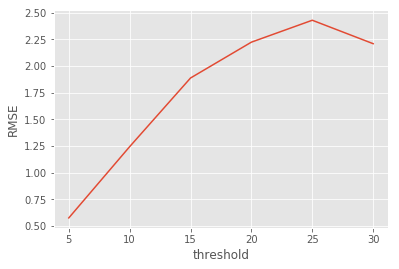

In [396]:
plt.plot([5,10,15,20,25,30], results_fixed)
#plt.plot([5,10,15,20,25,30], results_adapt)
plt.xlabel('threshold')
plt.ylabel('RMSE')
plt.savefig(r'D:\3A\Hidden Markov Model\Projet\RMSE_fixed.jpg')
plt.show()

# Partie épidémique

In [398]:
#Pour obtenir une représentation graphique de l'épidémie
def plot_results(rs, gs):
    n = len(rs) 
    infection_times = rs - gs
    max_t = int(np.ceil(np.max(rs)))
    infections = np.zeros(max_t)
    suceptible = np.zeros(max_t)
    removed = np.zeros(max_t)
    for t in range(max_t):
        removed[t] = len([x for x in rs if x < t])
        infections[t] = len([x for i,x in enumerate(rs) if x > t and infection_times[i] < t])#len([x for x in infection_times if x < t])
        suceptible[t] = n - removed[t] - infections[t]
    plt.plot(infections)
    plt.plot(removed)
    plt.plot(suceptible)
    plt.legend(["Infections", "Removed", "Suceptibles"])

## Data Processing

In [399]:
data = pd.read_csv('smallpox_abakaliki_1967.csv')
data['date_of_onset'] = pd.to_datetime(data['date_of_onset'])
data['day_of_onset'] = data['date_of_onset'] - data.loc[0,'date_of_onset']
data['day_of_onset'] = data['day_of_onset'].dt.days


#values from https://www.sciencedirect.com/science/article/pii/S1755436516300500?via%3Dihub#tbl0015
#model simplifié (sans la quarantaine et autres)
mean_fever = 2.49 #period in days
mean_rash = 16
std_fever = 0.88
std_rash = 2.83

n_dataset = len(data)
fever_period = np.random.gamma(np.cbrt((mean_fever*std_fever)**2),np.cbrt(std_fever**2/mean_fever), n_dataset)
rash_period = np.random.gamma(np.cbrt((std_rash*mean_rash)**2), np.cbrt(std_rash**2/mean_rash),n_dataset)
data['fever_period'] = fever_period
data['rash_period'] = rash_period
data['infectious_preriod'] = data['fever_period'] + data['rash_period']
data['removal'] = data['day_of_onset'] + data['infectious_preriod']
data['days_since_first_removal'] = data['removal'] - data.loc[0,'removal']
y_obs = np.sort(data['days_since_first_removal'].values)
y_obs

array([ 0.        , 10.85927024, 17.2327548 , 17.87397145, 20.36327768,
       20.90514443, 21.92237924, 25.17383135, 25.71725469, 27.75133242,
       35.39903681, 38.42145827, 38.50221627, 39.35336493, 39.42494256,
       40.67342003, 44.07709831, 50.75677019, 52.21704213, 52.31028769,
       53.87068177, 54.01221477, 56.23902154, 56.52245874, 58.31377587,
       59.62982862, 59.67158803, 60.9887205 , 62.43977949, 67.18492823,
       69.96969429, 80.61049614])

## Modélisation

In [400]:
def SellkeEpidemicSimulator(lamb, gs, ps):
  """
  -----------
  DESCRIPTION
  -----------
    
  Generate a dataset based on the latent variables :
      — g_1, ..., g_n : infectious periods
      - p_2, ..., p_n : pressure thresholds
      
  Output daset :
      - r_1, ..., r_n : removal times
  
  ------
  INPUTS
  ------
  
  n (int): population size
  lamb (float): infection rate
  gs (list of n floats): infectious periods (in days)
  ps (list of n-1 floats): pressure tresholds

  ------
  OUTPUT
  ------

  rs (list of n int): removal times (int days)  
  """
    n = len(gs)
    beta = lamb/n
    rs = [np.inf for i in range(n)]
    rs[0] = gs[0]
    I = 1
    t = 0
    p = 0
    while I > 0:
        try:
            p_a, a = min([(x, i) for i, x in enumerate(ps) if x > p], key = lambda t: t[0])
        except:
            p_a = np.inf
        try:
            r_b, b = min([(x, i) for i, x in enumerate(rs) if x > t], key = lambda t: t[0])
        except:
            r_b = np.inf
        p_prime = p + beta * I * (r_b - t)
        if p_a < p_prime:
            I += 1
            t += (p_a-p)/(beta * I)
            rs[a] = float(t + (p_a-p)/(beta * I) + gs[a])
            p = p_a
        else:
            I -= 1
            t = r_b
            p = p_prime
    return np.array(rs)

In [401]:
def f_q2rs(q, theta):
    #theta = (lambda, gamma)
    lamb = theta[0]
    gamma = theta[1]
    m = len(q)//2
    gs = np.array([F_inf_inv(x, gamma) for x in q[0:m]])
    ps = np.array([F_press_inv(x) for x in q[m:2*m]])
    rs = SellkeEpidemicSimulator(lamb, gs, ps)
    return rs, ps

def DistanceFunction(x, y_obs, theta, G, k=1000):
    rs, ps = G(x, theta)
    rs_raw = np.sort(rs[rs != np.inf])
    y_sim = rs_raw - rs_raw[0]
    rho = np.sort(ps)
    nu = min(len(y_sim), len(y_obs))
    total_rho = np.sum(rho)
    a = np.sqrt(np.sum((y_obs[0:nu-1] - y_sim[0:nu-1]) ** 2))
    if len(y_sim) > len(y_obs):
        b = sum([k + total_rho - x for x in rho[nu:]])
    else :
        b = sum([k + x for x in rho[nu:]])
    return a+b

def F_inf_inv(x, gamma):
    return -(1/gamma) * np.log(1-x)

def F_press_inv(x):
    return -np.log(1-x)

In [402]:
def exp10(theta):
    prod = 1
    for x in theta:
        if x >= 0:
            prod = prod * (10 * np.exp(-10 * x))
        else:
            prod = 0
    return prod
    
def norm_pdf(theta_prime, theta):
    prod = 1
    for i in range(len(theta)):
        prod = prod * norm.pdf(theta_prime[i], loc=theta[i], scale=scale)
    return prod

def norm_kernel(theta):
    while True:
        new_theta = norm.rvs(loc=theta, scale=scale)
        if (new_theta[0]<0) or (new_theta[1]<0):
            pass
        else:
            return new_theta

## Implémentation

In [403]:
#Paramètre d'échelle du kernel gaussien (RE-ABC)
scale = 0.2

En raison du temps de calcul trop long sur les données réelles on teste sur une petite épidémie simulée, avec des paramètres connus, pour valider la démarche.

In [404]:
#Génération du dataset
n = 5
lamb_0 = float(np.random.exponential(scale=.1, size=1))
gamma_0 = float(np.random.exponential(scale=.1, size=1))
R0_real = lamb_0/gamma_0
x = np.random.uniform(0, 1, 2*n)
rs, _ = f_q2rs(x, theta=(lamb_0, gamma_0))
rs, R0_real

(array([10.8096565,        inf,        inf,        inf,        inf]),
 1.1789773932443508)

In [405]:
#Définition du modèle
fk1 = adapt_RE_FK(T_max=100, accept_rate=0.7, eps_target=1001, shape=2*n, data=y_obs, theta=(lamb_0, gamma_0))
re_abc1 = RE_ABC(theta0=(lamb, gamma), prior=exp10, q=norm_pdf, q_ker=norm_kernel, refk=fk1, N=50, print_step=True)

TypeError: __init__() got an unexpected keyword argument 'size_n'

In [ ]:
#Itérations
re_abc1.run(300)

In [ ]:
#Visualisation de l'exploration de l'espace du paramètre theta
acc = re_abc1.theta_list
rej = re_abc1.theta_list_r
df_acc = pd.DataFrame(data=acc, columns=['lambda', 'gamma'])
df_acc['acc/rej'] = 'acc'
df_rej = pd.DataFrame(data=rej, columns=['lambda', 'gamma'])
df_rej['acc/rej'] = 'rej'
df = pd.concat([df_acc, df_rej])

sns.scatterplot(data=df, x='lambda', y='gamma', hue='acc/rej')

In [ ]:
#Estimation de lambda et gamma
t_raw = re_abc1.theta_list[2:]
t = np.unique(np.vstack(t_raw), axis=0)
np.mean(t[:,0]), np.mean(t[:,1]), np.std(t[:,0]), np.std(t[:,1])